In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.metrics import precision_recall_curve, roc_curve, average_precision_score, roc_auc_score

from script import utils
from script.utils import free_mem

from script.datasets import Dataset

sns.set()

In [2]:
utils.set_random_seed(42)

Random seed 42 set.


In [3]:
VARIABLES = ["dimuon_deltar", "dimuon_deltaphi", "dimuon_deltaeta", "met_pt", 
             "deltar_bjet1_dimuon", "deltapt_bjet1_dimuon", "deltaeta_bjet1_dimuon", 
             "bjet_1_pt", "bjet_1_eta", "deltaphi_bjet1_dimuon",
             "ljet_1_pt", "ljet_1_eta", "bjet_n", "ljet_n"]

In [4]:
def sample(df, amount: int, seed):
    if amount > df.shape[0]:
        x = []
        
        while amount > 0:
            x.append(df.sample(n=min(amount, df.shape[0]), random_state=seed))
            amount -= df.shape[0]
        
        return pd.concat(x, axis=0)
    
    return df.sample(n=amount, random_state=seed)

In [5]:
def train_val_test_split(dataset, valid_size=0.25, test_size=0.2, seed=utils.SEED):
    sig = dataset.signal
    bkg = dataset.background
    
    # test split
    train_sig, test_sig = train_test_split(sig, test_size=test_size, random_state=seed)
    train_bkg, test_bkg = train_test_split(bkg, test_size=test_size, random_state=seed)
    
    # train-valid split
    train_sig, valid_sig = train_test_split(train_sig, test_size=valid_size, random_state=seed)
    train_bkg, valid_bkg = train_test_split(train_bkg, test_size=valid_size, random_state=seed)
    
    return (train_sig, train_bkg), (valid_sig, valid_bkg), (test_sig, test_bkg)


In [6]:
class BalancedSequence(tf.keras.utils.Sequence):
    def __init__(self, signal: pd.DataFrame, background: pd.DataFrame, mass, category: int, batch_size: int, 
                 case: int, features: list, delta=50, balance=True, seed=utils.SEED):
        
        self.should_balance = bool(balance)
        
        sig = signal[signal['mA'] == mass]
        bkg = background
        
        # case
        if case == 1:
            # random flat background
            pass
        else:
            # case 2: bkg centered around mass in dimuon_M
            bkg = bkg[(bkg['dimuon_M'] > mass - delta) & (bkg['dimuon_M'] < mass + delta)]
        
        self.sig = sig
        
        if self.should_balance:
            self.bkg = {k: bkg[bkg['name'] == k] for k in bkg['name'].unique()}
        else:
            self.bkg = bkg
        
        self.rnd = np.random.RandomState(seed)
        
        self.sig_batch = batch_size // 2
        self.bkg_batch = self.sig_batch // len(self.bkg.keys())
        
        self.features = features
    
    def __len__(self):
        return self.sig.shape[0] // self.sig_batch
    
    def __getitem__(self, idx):
        if self.should_balance:
            df = [sample(v, amount=self.bkg_batch, seed=self.rnd) for v in self.bkg.values()]
        else:
            df = [sample(self.bkg, amount=self.bkg_batch, seed=self.rnd)]
        
        df.append(sample(self.sig, amount=self.sig_batch, seed=self.rnd))
        
        df = pd.concat(df, axis=0)
        
        x = df[self.features].values
        m = np.reshape(df['mA'].values, newshape=(-1, 1))
        y = np.reshape(df['type'].values, newshape=(-1, 1))
        
        return dict(x=x, m=m), y


In [7]:
def dataset_from_sequence(sequence: tf.keras.utils.Sequence, prefetch=2):
    def gen():    
        for i in range(len(sequence)):
            yield sequence[0]
            
    tf_data = tf.data.Dataset.from_generator(
        gen, 
        output_types=({'x': tf.float32, 'm': tf.float32}, tf.float32))
    
    return tf_data.prefetch(prefetch)

In [9]:
def performance_plot(model, dataset, mass: int, category: int, case: int, signal: str, delta=50, 
                     bins=20, size=(10, 9), legend='best', title='NN output distribution', seed=utils.SEED,
                     path='plot', save=None):
    
    fig, axes = plt.subplots(nrows=1, ncols=2)
    
    fig.set_figwidth(size[0] * 2)
    fig.set_figheight(size[1])
    
    sig = dataset.signal[dataset.signal['mA'] == mass]
    sig = sig[(sig['dimuon_M'] >= mass - delta) & (sig['dimuon_M'] < mass + delta)]
    bkg = dataset.background
    
    # case
    if case == 2:
        bkg = bkg[(bkg['dimuon_M'] >= mass - delta) & (bkg['dimuon_M'] < mass + delta)]
    
    num_sig = sig.shape[0]
    
    # prepare data
    x = pd.concat([sig[dataset.columns['feature']],
                   bkg[dataset.columns['feature']]], axis=0).values

    y = np.reshape(pd.concat([sig['type'], bkg['type']], axis=0).values, newshape=[-1])
    x = dict(x=x, m=np.zeros_like(y[:, np.newaxis]))
    
    # predict data
    out = model.predict(x=x, batch_size=1024, verbose=0)
    out = np.asarray(out)
    
    y_sig = np.squeeze(out[y == 1.0])
    y_bkg = np.squeeze(out[y == 0.0])
    
    # compute weights
    w_bkg = bkg['weight'].values
    
    h_bkg, _ = np.histogram(y_bkg, bins=bins, weights=w_bkg)
    h_bkg = np.sum(h_bkg)
    
    h_sig, _ = np.histogram(y_sig, bins=bins)
    h_sig = np.sum(h_sig)
    
    w_sig = np.ones_like(y_sig) * (h_bkg / h_sig)
    w = np.concatenate([w_sig, w_bkg], axis=0)
    
    str1 = 'all background' if case == 1 else f'@{(int(mass - delta), int(mass + delta))} dimuon_M (bkg)'
    
    # PR-curve
    from sklearn.metrics import PrecisionRecallDisplay
    
    PrecisionRecallDisplay.from_predictions(y_true=y, y_pred=out, sample_weight=w, ax=axes[0],
                                            name=f'NN @ {int(mass)}mA (signal {signal}), {str1}')
    axes[0].set_title(f'[case {case}] PR Curve (category {category})')
    
    # ROC curve
    from sklearn.metrics import RocCurveDisplay
    
    RocCurveDisplay.from_predictions(y_true=y, y_pred=out, sample_weight=w, ax=axes[1],
                                     name=f'NN @ {int(mass)}mA (signal {signal}), {str1}')
    axes[1].set_title(f'[case {case}] ROC Curve (category {category})')
    
    fig.tight_layout()
    
    if isinstance(save, str):
        path = utils.makedir(path)
        plt.savefig(os.path.join(path, f'{save}.png'), bbox_inches='tight')


In [10]:
def cmsplot(model, dataset, mass: int, category: int, case: int, signal: str, delta=50, bins=20, 
            size=(12, 10), legend='best', title='NN output distribution', seed=utils.SEED,
            path='plot', save=None, show=True, ax=None):
    
    if ax is None:
        fig = plt.figure(figsize=size)
        ax = fig.gca()
    
    sig = dataset.signal[dataset.signal['mA'] == mass]
    sig = sig[(sig['dimuon_M'] >= mass - delta) & (sig['dimuon_M'] < mass + delta)]
    bkg = dataset.background
    
    # case
    if case == 2:
        bkg = bkg[(bkg['dimuon_M'] >= mass - delta) & (bkg['dimuon_M'] < mass + delta)]
    
    num_sig = sig.shape[0]
    
    # prepare data
    x = pd.concat([sig[dataset.columns['feature']],
                   bkg[dataset.columns['feature']]], axis=0).values

    y = np.reshape(pd.concat([sig['type'], bkg['type']], axis=0).values, newshape=[-1])
    x = dict(x=x, m=np.zeros_like(y[:, np.newaxis]))
    
    # predict data
    out = model.predict(x=x, batch_size=1024, verbose=0)
    out = np.asarray(out)

    y_sig = np.squeeze(out[y == 1.0])
    y_bkg = np.squeeze(out[y == 0.0])

    w_bkg = bkg['weight'].values
    w_sig = np.ones_like(y_sig)
    
    # plot
    names = dataset.names_df.loc[bkg.index.values]
    df = pd.DataFrame({'Output': y_bkg, 'Bkg': np.squeeze(names), 'weight': w_bkg})
    
    # plot histograms
    sns.histplot(data=df, x='Output', hue='Bkg', multiple='stack', edgecolor='.3', linewidth=0.5, bins=bins,
                 weights='weight', ax=ax,
                 palette={'DY': 'green', 'TTbar': 'red', 'ST': 'blue', 'diboson': 'yellow'})
    
    h_bkg, _ = np.histogram(y_bkg, bins=bins, weights=w_bkg)
    h_bkg = np.sum(h_bkg)
    
    h_sig, _ = np.histogram(y_sig, bins=bins)
    h_sig = np.sum(h_sig)
    
    w_sig = np.ones_like(y_sig) * (h_bkg / h_sig)
    
    ax.hist(y_sig, bins=bins, alpha=0.5, label='signal', color='purple', edgecolor='purple', 
            linewidth=2, hatch='//', histtype='step',
            weights=w_sig)
    
    # compute significance
    sig_mask = np.squeeze(y == 1.0)
    bkg_mask = np.squeeze(y == 0.0)

    cuts = np.linspace(0.0, 1.0, num=bins)
    ams = []
    w = np.concatenate([w_sig, w_bkg], axis=0)
    
    bx = ax.twinx()
    
    s, _ = np.histogram(y_sig, bins=bins, weights=w_sig)
    b, _ = np.histogram(y_bkg, bins=bins, weights=w_bkg)
    
    for i in range(s.shape[0]):
        s_i = np.sum(s[i:])
        b_i = np.sum(b[i:])
        
        ams.append(s_i / np.sqrt(s_i + b_i))

    k = np.argmax(ams)
    
    # add stuff to plot
    bx.grid(False)
    bx.plot(cuts, ams, color='g', label='Significance')

    ax.axvline(x=cuts[k], linestyle='--', linewidth=2, color='g',
               label=f'{round(cuts[k], 3)}: {round(ams[k], 3)}')

    bx.set_ylabel(r'Significance: $s/\sqrt{s+b}$')
    
    leg = ax.get_legend()
    ax.legend(loc='upper left')
    ax.add_artist(leg)
    
    ax.set_xlabel('Class Label Probability')
    ax.set_ylabel('Weighted Num. Events')
    
    # title
    str0 = f'[Case {case}] Category-{category} (#bins = {bins})'
    str1 = 'all background' if case == 1 else f'@{(int(mass - delta), int(mass + delta))} dimuon_M (bkg)'
    str2 = f'{title} @ {int(mass)}mA (signal {signal}), {str1}'
    str3 = f'# signal = {sig.shape[0]}, # bkg = {bkg.shape[0]}'
    
    ax.set_title(f'{str0}\n{str2}\n{str3}')
    
    if isinstance(save, str):
        path = utils.makedir(path)
        plt.savefig(os.path.join(path, f'{save}.png'), bbox_inches='tight')
    
    if show:
        plt.show()


In [11]:
def compare_significance(models: list, dataset, mass: float, *args, path='plot', save=None, size=(12, 10), 
                         share_y=False, **kwargs):
    fig, axes = plt.subplots(nrows=1, ncols=2, sharey=bool(share_y))
    
    fig.set_figwidth(size[0] * 2)
    fig.set_figheight(size[1])
    
    for i, model in enumerate(models):
        cmsplot(model, dataset, mass, *args, **kwargs, case=2, save=None, show=False, ax=axes[i])
    
    if isinstance(save, str):
        path = utils.makedir(path)
        plt.savefig(os.path.join(path, f'{save}_{int(mass)}mA.png'), bbox_inches='tight')
    
    plt.show()

In [12]:
def roc_auc(true, pred, weights, cut: float, eps=1e-4):
    from sklearn.metrics import roc_curve, roc_auc_score
    
    fpr, tpr, t = roc_curve(true, pred, sample_weight=weights)
    auc = roc_auc_score(true, pred, average='micro', sample_weight=weights)
    
    # find significance along the curve
    mask = (t > cut - eps) & (t < cut + eps)
    
    return fpr, tpr, auc, fpr[mask], tpr[mask]


def pr_auc(true, pred, weights, cut: float, eps=1e-4):
    from sklearn.metrics import precision_recall_curve, average_precision_score
    
    precision, recall, t = precision_recall_curve(true, pred, sample_weight=weights)
    auc = average_precision_score(true, pred, average='micro', sample_weight=weights)
    
    # find significance along the curve
    mask = (t > cut - eps) & (t < cut + eps)
    mask = np.array(list(mask) + [False])
    
    return precision, recall, auc, precision[mask], recall[mask]


def plot_roc(dataset, models_and_cuts: dict, mass=400.0, delta=50.0, bins=20, size=(12, 10), digits=3,
             path='plot', save=None, **kwargs):
    def get_predictions_and_weights(model, x, y, bkg):
        out = model.predict(x=x, batch_size=1024, verbose=0)
        out = np.asarray(out)

        y_sig = np.squeeze(out[y == 1.0])
        y_bkg = np.squeeze(out[y == 0.0])

        # compute weights
        w_bkg = bkg['weight'].values

        h_bkg, _ = np.histogram(y_bkg, bins=bins, weights=w_bkg)
        h_bkg = np.sum(h_bkg)

        h_sig, _ = np.histogram(y_sig, bins=bins)
        h_sig = np.sum(h_sig)

        w_sig = np.ones_like(y_sig) * (h_bkg / h_sig)
        w = np.concatenate([w_sig, w_bkg], axis=0)
        
        return out, w
    
    sig = dataset.signal[dataset.signal['mA'] == mass]
    sig = sig[(sig['dimuon_M'] >= mass - delta) & (sig['dimuon_M'] < mass + delta)]
    
    bkg = dataset.background
    bkg = bkg[(bkg['dimuon_M'] >= mass - delta) & (bkg['dimuon_M'] < mass + delta)]

    # prepare data
    x = pd.concat([sig[dataset.columns['feature']],
                   bkg[dataset.columns['feature']]], axis=0).values

    y = np.reshape(pd.concat([sig['type'], bkg['type']], axis=0).values, newshape=[-1])
    x = dict(x=x, m=np.zeros_like(y[:, np.newaxis]))
    
    # predict data
    plt.figure(figsize=size)
    plt.title('ROC')
    
    for k, (model, cut) in models_and_cuts.items():
        out, w = get_predictions_and_weights(model, x, y, bkg)
        
        fpr, tpr, auc, cut_fpr, cut_tpr = roc_auc(true=y, pred=out, weights=w, cut=cut, **kwargs)
    
        plt.plot(fpr, tpr, label=f'AUC ({k}) {np.round(auc, digits)}')
        plt.scatter(cut_fpr, cut_tpr, label=f'significance @ {cut}')
    
    plt.xlabel('Background Efficiency (False Positive Rate)')
    plt.ylabel('Signal Efficienty (True Positive Rate)')
    
    plt.legend(loc='lower right')
    
    if isinstance(save, str):
        path = utils.makedir(path)
        plt.savefig(os.path.join(path, f'{save}_{int(mass)}mA.png'), bbox_inches='tight')
    
    plt.show()

    
def plot_pr(dataset, models_and_cuts: dict, mass=400.0, delta=50.0, bins=20, size=(12, 10), digits=3, 
            path='plot', save=None, **kwargs):
    def get_predictions_and_weights(model, x, y, bkg):
        out = model.predict(x=x, batch_size=1024, verbose=0)
        out = np.asarray(out)

        y_sig = np.squeeze(out[y == 1.0])
        y_bkg = np.squeeze(out[y == 0.0])

        # compute weights
        w_bkg = bkg['weight'].values

        h_bkg, _ = np.histogram(y_bkg, bins=bins, weights=w_bkg)
        h_bkg = np.sum(h_bkg)

        h_sig, _ = np.histogram(y_sig, bins=bins)
        h_sig = np.sum(h_sig)

        w_sig = np.ones_like(y_sig) * (h_bkg / h_sig)
        w = np.concatenate([w_sig, w_bkg], axis=0)
        
        return out, w
    
    sig = dataset.signal[dataset.signal['mA'] == mass]
    sig = sig[(sig['dimuon_M'] >= mass - delta) & (sig['dimuon_M'] < mass + delta)]
    
    bkg = dataset.background
    bkg = bkg[(bkg['dimuon_M'] >= mass - delta) & (bkg['dimuon_M'] < mass + delta)]

    # prepare data
    x = pd.concat([sig[dataset.columns['feature']],
                   bkg[dataset.columns['feature']]], axis=0).values

    y = np.reshape(pd.concat([sig['type'], bkg['type']], axis=0).values, newshape=[-1])
    x = dict(x=x, m=np.zeros_like(y[:, np.newaxis]))
    
    # predict data
    plt.figure(figsize=size)
    plt.title('PR Curve')
    
    for k, (model, cut) in models_and_cuts.items():
        out, w = get_predictions_and_weights(model, x, y, bkg)
        
        precision, recall, auc, cut_prec, cut_rec = pr_auc(true=y, pred=out, weights=w, cut=cut, **kwargs)
        
        plt.plot(recall, precision, label=f'AUC ({k}) {np.round(auc, digits)}')
        plt.scatter(cut_rec, cut_prec, label=f'significance @ {cut}')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    
    plt.legend(loc='lower left')
    
    if isinstance(save, str):
        path = utils.makedir(path)
        plt.savefig(os.path.join(path, f'{save}_{int(mass)}mA.png'), bbox_inches='tight')
    
    plt.show()


In [14]:
def posteriori_plot(dataset, model, variables: list, mass, cut: float, category: int, case: int, delta=50.0,
                    size=(12, 10), legend='best', bins=25,
                    path='plot', weight=False, seed=utils.SEED, save=None, min_limit=None, max_limit=None):
    sig = dataset.signal[dataset.signal['mA'] == mass]
    bkg = dataset.background
    
    # case
    if case == 2:
        bkg = bkg[(bkg['dimuon_M'] >= mass - delta) & (bkg['dimuon_M'] < mass + delta)]
    
    ds = pd.concat([sig, bkg], axis=0)
    num_sig = sig.shape[0]
    
    # prepare data
    x = pd.concat([sig[dataset.columns['feature']],
                   bkg[dataset.columns['feature']]], axis=0).values

    y = np.reshape(pd.concat([sig['type'], bkg['type']], axis=0).values, newshape=[-1])
    x = dict(x=x, m=np.zeros_like(y[:, np.newaxis]))
    
    # predict data
    out = model.predict(x=x, batch_size=1024, verbose=0)
    out = np.asarray(out)
    
    sig_mask = np.squeeze(out >= cut) & (y == 1.0)
    bkg_mask = np.squeeze(out < cut) & (y == 0.0)
    
    y_sig = np.squeeze(out[sig_mask])
    y_bkg = np.squeeze(out[bkg_mask])
    
    w_bkg = ds[bkg_mask]['weight'].values
    w_sig = np.ones_like(y_sig)
    
    # compute signal weights
    h_bkg, _ = np.histogram(y_bkg, bins=bins, weights=w_bkg)
    h_bkg = np.sum(h_bkg)
    
    h_sig, _ = np.histogram(y_sig, bins=bins)
    h_sig = np.sum(h_sig)
    
    w_sig = np.ones_like(y_sig) * (h_bkg / h_sig)
    
    # plot
    names = dataset.names_df.loc[ds[bkg_mask].index]
    figures = []
    
    for col in variables:
        fig = plt.figure(figsize=size)
        ax = fig.gca()
        
        s = ds[sig_mask][col]
        b = ds[bkg_mask][col]
        
        df = pd.DataFrame({col: b, 'Bkg': np.squeeze(names), 'weight': w_bkg})
        
        if ('met' in col) or ('pt' in col):
            n_bins = 50
            max_limit = 500.0
        
        elif col == 'ljet_n':
            n_bins = 25
            max_limit = 11.0
        
        elif col == 'dimuon_M':
            n_bins = 25
            max_limit = 500.0
            min_limit = 300
        else:
            n_bins = 25
            max_limit = None
        
        range_min = min(b.min(), s.min())
        range_max = max(b.max(), s.max())

        if isinstance(min_limit, (int, float)):
            range_min = max(range_min, min_limit)
        
        if isinstance(max_limit, (int, float)):
            range_max = min(range_max, max_limit)

        # plot histograms
        sns.histplot(data=df, x=col, hue='Bkg', multiple='stack', edgecolor='.3', linewidth=0.5, bins=n_bins,
                     weights='weight', ax=ax, binrange=(range_min, range_max),
                     palette={'DY': 'green', 'TTbar': 'red', 'ST': 'blue', 'diboson': 'yellow'})

        ax.hist(s, bins=n_bins, alpha=0.7, label='signal', color='purple', edgecolor='purple', 
                linewidth=2, hatch='//', histtype='step',
                range=(range_min, range_max), weights=w_sig)

        leg = ax.get_legend()
        ax.legend(loc='upper left')
        ax.add_artist(leg)

        ax.set_xlabel(col)
        ax.set_ylabel('Count')
    
        figures.append(fig)
    
        if isinstance(save, str):
            path = utils.makedir(path)
            plt.savefig(os.path.join(path, f'{save}.png'), bbox_inches='tight')
    
        plt.show()
    
    return figures

In [ ]:
def posteriori_plot2(dataset, models: list, variables: list, mass, cuts: list, category: int, case: int, 
                     delta=50.0, size=(12, 10), legend='best', bins=25,
                     path='plot', weight=False, seed=utils.SEED, save=None, min_limit=None, max_limit=None):
    
    def predict(model, x, cut):
        out = model.predict(x=x, batch_size=1024, verbose=0)
        out = np.asarray(out)
    
        sig_mask = np.squeeze(out >= cut) & (y == 1.0)
        bkg_mask = np.squeeze(out < cut) & (y == 0.0)

        y_sig = np.squeeze(out[sig_mask])
        y_bkg = np.squeeze(out[bkg_mask])

        w_bkg = ds[bkg_mask]['weight'].values
        w_sig = np.ones_like(y_sig)

        # compute signal weights
        h_bkg, _ = np.histogram(y_bkg, bins=bins, weights=w_bkg)
        h_bkg = np.sum(h_bkg)

        h_sig, _ = np.histogram(y_sig, bins=bins)
        h_sig = np.sum(h_sig)

        w_sig = np.ones_like(y_sig) * (h_bkg / h_sig)
        names = dataset.names_df.loc[ds[bkg_mask].index]
        
        return out, (sig_mask, bkg_mask), (y_sig, y_bkg), (w_sig, w_bkg), names 
    
    sig = dataset.signal[dataset.signal['mA'] == mass]
    bkg = dataset.background
    
    # case
    if case == 2:
        sig = sig[(sig['dimuon_M'] >= mass - delta) & (sig['dimuon_M'] < mass + delta)]
        bkg = bkg[(bkg['dimuon_M'] >= mass - delta) & (bkg['dimuon_M'] < mass + delta)]
    
    ds = pd.concat([sig, bkg], axis=0)
    num_sig = sig.shape[0]
    
    # prepare data
    x = pd.concat([sig[dataset.columns['feature']],
                   bkg[dataset.columns['feature']]], axis=0).values

    y = np.reshape(pd.concat([sig['type'], bkg['type']], axis=0).values, newshape=[-1])
    x = dict(x=x, m=np.zeros_like(y[:, np.newaxis]))
    
    # predict data
    out1, masks1, y1, w1, names1 = predict(models[0], x, cuts[0])
    out2, masks2, y2, w2, names2 = predict(models[1], x, cuts[1])
    
    out = [out1, out2]
    mask = [masks1, masks2]
    labels = [y1, y2]
    w = [w1, w2]
    names = [names1, names2]
    
    for col in variables:
        fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True)
        
        fig.set_figwidth(size[0] * 2)
        fig.set_figheight(size[1])
        
        ax = fig.gca()
        
        for i, ax in enumerate(axes):
            s = ds[mask[i][0]][col]
            b = ds[mask[i][1]][col]
        
            df = pd.DataFrame({col: b, 'Bkg': np.squeeze(names[i]), 'weight': w[i][1]})

            if ('met' in col) or ('pt' in col):
                n_bins = 50
                max_limit = 500.0

            elif col == 'ljet_n':
                n_bins = 25
                max_limit = 11.0

            elif col == 'dimuon_M':
                n_bins = 25
                max_limit = 500.0
                min_limit = 300
            else:
                n_bins = 25
                max_limit = None

            range_min = min(b.min(), s.min())
            range_max = max(b.max(), s.max())

            if isinstance(min_limit, (int, float)):
                range_min = max(range_min, min_limit)

            if isinstance(max_limit, (int, float)):
                range_max = min(range_max, max_limit)

            # plot histograms
            sns.histplot(data=df, x=col, hue='Bkg', multiple='stack', edgecolor='.3', linewidth=0.5, bins=n_bins,
                         weights='weight', ax=ax, binrange=(range_min, range_max),
                         palette={'DY': 'green', 'TTbar': 'red', 'ST': 'blue', 'diboson': 'yellow'})

            ax.hist(s, bins=n_bins, alpha=0.7, label='signal', color='purple', edgecolor='purple', 
                    linewidth=2, hatch='//', histtype='step',
                    range=(range_min, range_max), weights=w[i][0])

            leg = ax.get_legend()
            ax.legend(loc='upper left')
            ax.add_artist(leg)

            ax.set_xlabel(col)
            ax.set_ylabel('Count')
            
            fig.tight_layout()
        
        if isinstance(save, str):
            path = utils.makedir(path)
            plt.savefig(os.path.join(path, f'comparison_{col}_posteriori_{int(mass)}mA.png'), bbox_inches='tight')
        
        plt.show()

## Category 1


### bbH

In [13]:
VAR_CAT1 = ["dimuon_deltar", "dimuon_deltaphi", "dimuon_deltaeta", "met_pt", 
             "deltar_bjet1_dimuon", "deltapt_bjet1_dimuon", "deltaeta_bjet1_dimuon", 
             "bjet_1_pt", "bjet_1_eta", "deltaphi_bjet1_dimuon",
             "ljet_1_pt", "ljet_1_eta", "bjet_n", "ljet_n"]

In [14]:
data = Dataset()
data.load(signal='data/new/signal_bassociated_cat1.csv', 
          bkg='data/new/background_cat1.csv', feature_columns=VAR_CAT1)

data.ds.loc[data.ds['ljet_1_eta'] == -10, 'ljet_1_eta'] = -3.0

[signal] loading...
[background] loading...
[Dataset] loaded.


In [14]:
# split data
train, valid, test = train_val_test_split(data)

#### Case 1

In [15]:
# create sequences
train_seq = BalancedSequence(signal=train[0], background=train[1], mass=400.0, category=1,
                             case=1, batch_size=128, features=VAR_CAT1)

valid_seq = BalancedSequence(signal=valid[0], background=valid[1], mass=400.0, category=1,
                             case=1, batch_size=1024, features=VAR_CAT1, balance=False)

test_seq = BalancedSequence(signal=test[0], background=test[1], mass=400.0, category=1,
                            case=1, batch_size=1024, features=VAR_CAT1, balance=False)

In [16]:
# create tf.Datasets
train_ds = dataset_from_sequence(train_seq)
valid_ds = dataset_from_sequence(valid_seq)
test_ds = dataset_from_sequence(test_seq)

In [92]:
# create model
model, checkpoint = utils.get_compiled_non_parametric(data, save='new/nn-400-bbH-cat_1-case_1')

In [19]:
model.fit(x=train_ds, epochs=100, validation_data=valid_ds, verbose=2,
          callbacks=[checkpoint, EarlyStopping(patience=40)])

Epoch 1/100
403/403 - 19s - loss: 0.4349 - binary_accuracy: 0.7559 - auc: 0.8295 - precision: 0.7323 - recall: 0.8066 - class-loss: 0.5149 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 3.1820 - weight-norm: 20.4026 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0000e+00 - val_loss: 0.5082 - val_binary_accuracy: 0.8093 - val_auc: 0.9401 - val_precision: 0.9955 - val_recall: 0.8052
Epoch 2/100
403/403 - 17s - loss: 0.3842 - binary_accuracy: 0.8054 - auc: 0.8839 - precision: 0.7840 - recall: 0.8432 - class-loss: 0.4313 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 3.0886 - weight-norm: 20.6731 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0000e+00 - val_loss: 0.3529 - val_binary_accuracy: 0.8568 - val_auc: 0.9394 - val_precision: 0.9940 - val_recall: 0.8561
Epoch 3/100
403/403 - 17s - loss: 0.3935 - binary_accuracy: 0.8265 - auc: 0.9030 - precision: 0.8153 - recall: 0.8443 - class-loss: 0.3956 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 3.6261 - weight-norm: 20.9666 - adver

Epoch 23/100
403/403 - 14s - loss: 0.2721 - binary_accuracy: 0.8782 - auc: 0.9458 - precision: 0.8575 - recall: 0.9073 - class-loss: 0.2869 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 4.3798 - weight-norm: 25.4669 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0000e+00 - val_loss: 0.2502 - val_binary_accuracy: 0.9129 - val_auc: 0.9618 - val_precision: 0.9951 - val_recall: 0.9138
Epoch 24/100
403/403 - 14s - loss: 0.3856 - binary_accuracy: 0.8773 - auc: 0.9439 - precision: 0.8556 - recall: 0.9078 - class-loss: 0.2914 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 4.3579 - weight-norm: 25.6660 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0000e+00 - val_loss: 0.2055 - val_binary_accuracy: 0.9405 - val_auc: 0.9587 - val_precision: 0.9937 - val_recall: 0.9441
Epoch 25/100
403/403 - 14s - loss: 0.2482 - binary_accuracy: 0.8804 - auc: 0.9473 - precision: 0.8585 - recall: 0.9109 - class-loss: 0.2821 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 4.2459 - weight-norm: 25.8339 - ad

Epoch 45/100
403/403 - 15s - loss: 0.3182 - binary_accuracy: 0.8865 - auc: 0.9506 - precision: 0.8598 - recall: 0.9237 - class-loss: 0.2703 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 4.4380 - weight-norm: 29.2784 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0000e+00 - val_loss: 0.2887 - val_binary_accuracy: 0.8966 - val_auc: 0.9548 - val_precision: 0.9959 - val_recall: 0.8960
Epoch 46/100
403/403 - 15s - loss: 0.2411 - binary_accuracy: 0.8854 - auc: 0.9497 - precision: 0.8584 - recall: 0.9230 - class-loss: 0.2724 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 4.5362 - weight-norm: 29.4286 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0000e+00 - val_loss: 0.2834 - val_binary_accuracy: 0.9115 - val_auc: 0.9660 - val_precision: 0.9957 - val_recall: 0.9117
Epoch 47/100
403/403 - 15s - loss: 0.2234 - binary_accuracy: 0.8876 - auc: 0.9506 - precision: 0.8623 - recall: 0.9225 - class-loss: 0.2697 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 4.4322 - weight-norm: 29.5968 - ad

Epoch 67/100
403/403 - 18s - loss: 0.3395 - binary_accuracy: 0.8911 - auc: 0.9546 - precision: 0.8643 - recall: 0.9280 - class-loss: 0.2588 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 4.4475 - weight-norm: 32.4878 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0000e+00 - val_loss: 0.2448 - val_binary_accuracy: 0.9112 - val_auc: 0.9740 - val_precision: 0.9963 - val_recall: 0.9110
Epoch 68/100
403/403 - 17s - loss: 0.1996 - binary_accuracy: 0.8889 - auc: 0.9522 - precision: 0.8614 - recall: 0.9270 - class-loss: 0.2642 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 4.5607 - weight-norm: 32.6214 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0000e+00 - val_loss: 0.2961 - val_binary_accuracy: 0.8975 - val_auc: 0.9692 - val_precision: 0.9973 - val_recall: 0.8958
Epoch 69/100
403/403 - 18s - loss: 0.1922 - binary_accuracy: 0.8896 - auc: 0.9535 - precision: 0.8614 - recall: 0.9286 - class-loss: 0.2618 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 4.3990 - weight-norm: 32.7695 - ad

Epoch 89/100
403/403 - 17s - loss: 0.2972 - binary_accuracy: 0.8902 - auc: 0.9543 - precision: 0.8635 - recall: 0.9269 - class-loss: 0.2590 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 4.7718 - weight-norm: 35.2936 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0000e+00 - val_loss: 0.2763 - val_binary_accuracy: 0.8901 - val_auc: 0.9694 - val_precision: 0.9970 - val_recall: 0.8883
Epoch 90/100
403/403 - 17s - loss: 0.2240 - binary_accuracy: 0.8895 - auc: 0.9535 - precision: 0.8638 - recall: 0.9248 - class-loss: 0.2605 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 4.3250 - weight-norm: 35.4401 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0000e+00 - val_loss: 0.2579 - val_binary_accuracy: 0.9136 - val_auc: 0.9796 - val_precision: 0.9973 - val_recall: 0.9125
Epoch 91/100
403/403 - 19s - loss: 0.2321 - binary_accuracy: 0.8940 - auc: 0.9557 - precision: 0.8667 - recall: 0.9313 - class-loss: 0.2536 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 4.3214 - weight-norm: 35.5670 - ad

In [93]:
utils.load_from_checkpoint(model, path='new/nn-400-bbH-cat_1-case_1')

Loaded from "weights\new/nn-400-bbH-cat_1-case_1\weights-50-0.980"


In [21]:
_ = model.evaluate(x=test_ds, verbose=2)

16/16 [==============================] - 0s 24ms/step - loss: 0.2529 - binary_accuracy: 0.9170 - auc: 0.9784 - precision: 0.9969 - recall: 0.9164


[0.25286996364593506,
 0.9169793725013733,
 0.9784045219421387,
 0.9969455599784851,
 0.9163818359375]

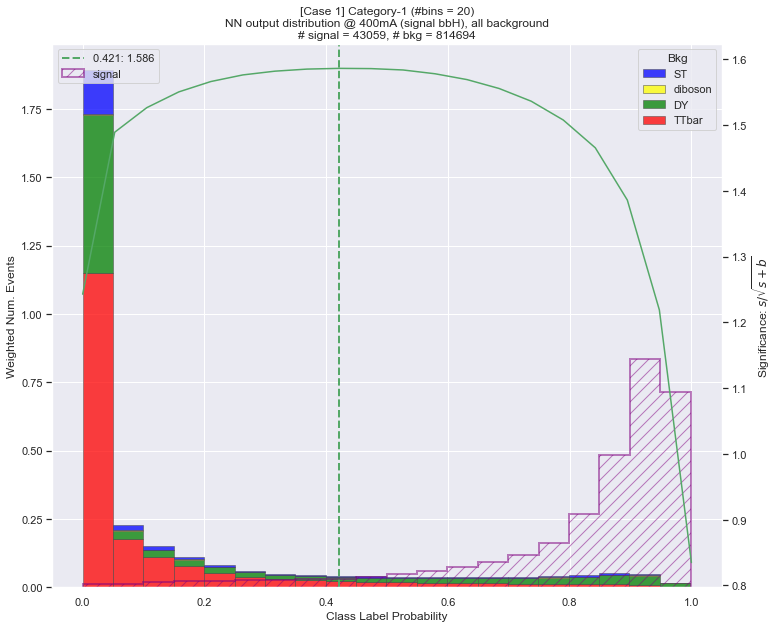

In [14]:
cmsplot(model, data, mass=400, category=1, case=1, signal='bbH',
        path='plot/case1/bbH/balanced/cat-1/model', save='significance_400mA')

See how it performs on case 2, too:

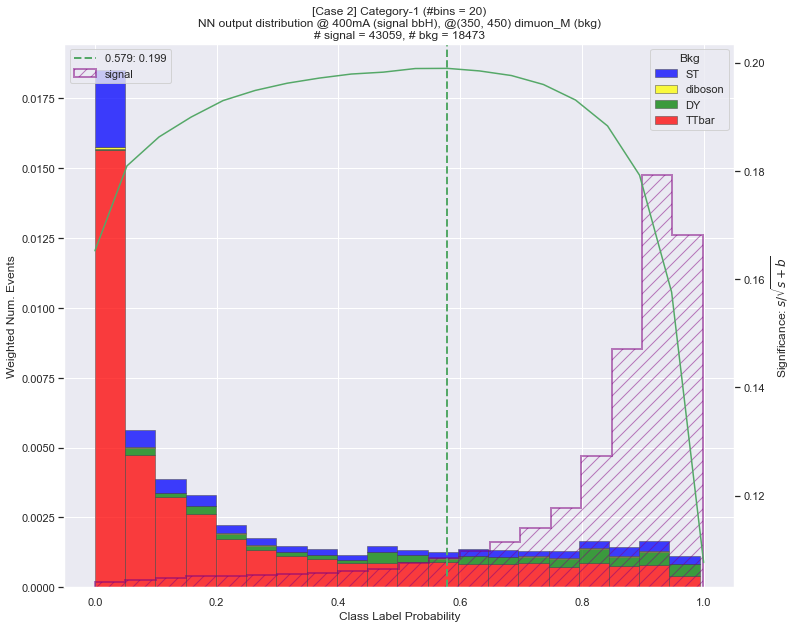

In [15]:
cmsplot(model, data, mass=400, category=1, case=2, signal='bbH',
        path='plot/case1/bbH/balanced/cat-1/model', save='significance_400mA')

#### Case 2

In [23]:
# create sequences
train_seq = BalancedSequence(signal=train[0], background=train[1], mass=400.0, category=1,
                             case=2, batch_size=128, features=VAR_CAT1)

valid_seq = BalancedSequence(signal=valid[0], background=valid[1], mass=400.0, category=1,
                             case=2, batch_size=1024, features=VAR_CAT1, balance=False)

test_seq = BalancedSequence(signal=test[0], background=test[1], mass=400.0, category=1,
                            case=2, batch_size=1024, features=VAR_CAT1, balance=False)

In [24]:
# create tf.Datasets
train_ds = dataset_from_sequence(train_seq)
valid_ds = dataset_from_sequence(valid_seq)
test_ds = dataset_from_sequence(test_seq)

In [105]:
# create model
model, checkpoint = utils.get_compiled_non_parametric(data, save='new/nn-400-bbH-cat_1-case_2',
                                                      dropout=0.4)

In [26]:
model.fit(x=train_ds, epochs=100, validation_data=valid_ds, verbose=2,
          callbacks=[checkpoint, EarlyStopping(patience=40)])

Epoch 1/100
403/403 - 10s - loss: 0.6006 - binary_accuracy: 0.6764 - auc: 0.7263 - precision: 0.6946 - recall: 0.6295 - class-loss: 0.7893 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 4.2033 - weight-norm: 20.3385 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0000e+00 - val_loss: 0.4476 - val_binary_accuracy: 0.8745 - val_auc: 0.8961 - val_precision: 0.9866 - val_recall: 0.8813
Epoch 2/100
403/403 - 8s - loss: 0.5718 - binary_accuracy: 0.7666 - auc: 0.8314 - precision: 0.7494 - recall: 0.8010 - class-loss: 0.5189 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 1.4889 - weight-norm: 20.5077 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0000e+00 - val_loss: 0.4119 - val_binary_accuracy: 0.8748 - val_auc: 0.9227 - val_precision: 0.9904 - val_recall: 0.8782
Epoch 3/100
403/403 - 7s - loss: 0.5157 - binary_accuracy: 0.7826 - auc: 0.8498 - precision: 0.7563 - recall: 0.8339 - class-loss: 0.4905 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 1.2131 - weight-norm: 20.7596 - adversa

Epoch 23/100
403/403 - 8s - loss: 0.5226 - binary_accuracy: 0.8486 - auc: 0.9200 - precision: 0.8691 - recall: 0.8207 - class-loss: 0.3594 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 2.8599 - weight-norm: 29.7529 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0000e+00 - val_loss: 0.2760 - val_binary_accuracy: 0.8683 - val_auc: 0.9373 - val_precision: 0.9941 - val_recall: 0.8680
Epoch 24/100
403/403 - 7s - loss: 0.4176 - binary_accuracy: 0.8480 - auc: 0.9201 - precision: 0.8675 - recall: 0.8215 - class-loss: 0.3589 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 2.9661 - weight-norm: 30.2755 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0000e+00 - val_loss: 0.2558 - val_binary_accuracy: 0.8725 - val_auc: 0.9323 - val_precision: 0.9922 - val_recall: 0.8741
Epoch 25/100
403/403 - 8s - loss: 0.3444 - binary_accuracy: 0.8489 - auc: 0.9209 - precision: 0.8715 - recall: 0.8185 - class-loss: 0.3580 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 2.8126 - weight-norm: 30.8181 - adver

Epoch 45/100
403/403 - 8s - loss: 0.4056 - binary_accuracy: 0.8605 - auc: 0.9305 - precision: 0.8732 - recall: 0.8434 - class-loss: 0.3371 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 3.2351 - weight-norm: 41.3933 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0000e+00 - val_loss: 0.2724 - val_binary_accuracy: 0.8721 - val_auc: 0.9433 - val_precision: 0.9940 - val_recall: 0.8721
Epoch 46/100
403/403 - 8s - loss: 0.3176 - binary_accuracy: 0.8619 - auc: 0.9330 - precision: 0.8782 - recall: 0.8403 - class-loss: 0.3303 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 3.0240 - weight-norm: 41.8688 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0000e+00 - val_loss: 0.2773 - val_binary_accuracy: 0.8738 - val_auc: 0.9360 - val_precision: 0.9925 - val_recall: 0.8752
Epoch 47/100
403/403 - 8s - loss: 0.4013 - binary_accuracy: 0.8598 - auc: 0.9324 - precision: 0.8732 - recall: 0.8419 - class-loss: 0.3330 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 3.1227 - weight-norm: 42.3429 - adver

Epoch 67/100
403/403 - 7s - loss: 0.3154 - binary_accuracy: 0.8641 - auc: 0.9352 - precision: 0.8770 - recall: 0.8470 - class-loss: 0.3249 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 3.1946 - weight-norm: 51.6750 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0000e+00 - val_loss: 0.2528 - val_binary_accuracy: 0.8863 - val_auc: 0.9547 - val_precision: 0.9947 - val_recall: 0.8864
Epoch 68/100
403/403 - 7s - loss: 0.3683 - binary_accuracy: 0.8660 - auc: 0.9367 - precision: 0.8761 - recall: 0.8526 - class-loss: 0.3226 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 3.0985 - weight-norm: 52.1092 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0000e+00 - val_loss: 0.2438 - val_binary_accuracy: 0.8925 - val_auc: 0.9411 - val_precision: 0.9922 - val_recall: 0.8951
Epoch 69/100
403/403 - 7s - loss: 0.3769 - binary_accuracy: 0.8676 - auc: 0.9371 - precision: 0.8783 - recall: 0.8534 - class-loss: 0.3212 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 3.0186 - weight-norm: 52.5595 - adver

Epoch 89/100
403/403 - 7s - loss: 0.3032 - binary_accuracy: 0.8709 - auc: 0.9409 - precision: 0.8785 - recall: 0.8609 - class-loss: 0.3111 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 3.0700 - weight-norm: 61.0776 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0000e+00 - val_loss: 0.2308 - val_binary_accuracy: 0.9029 - val_auc: 0.9415 - val_precision: 0.9917 - val_recall: 0.9065
Epoch 90/100
403/403 - 7s - loss: 0.2912 - binary_accuracy: 0.8704 - auc: 0.9414 - precision: 0.8816 - recall: 0.8559 - class-loss: 0.3102 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 2.9611 - weight-norm: 61.4867 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0000e+00 - val_loss: 0.2349 - val_binary_accuracy: 0.9010 - val_auc: 0.9522 - val_precision: 0.9933 - val_recall: 0.9031
Epoch 91/100
403/403 - 8s - loss: 0.2603 - binary_accuracy: 0.8716 - auc: 0.9418 - precision: 0.8812 - recall: 0.8591 - class-loss: 0.3093 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 2.9964 - weight-norm: 61.9124 - adver

In [106]:
utils.load_from_checkpoint(model, path='new/nn-400-bbH-cat_1-case_2')

Loaded from "weights\new/nn-400-bbH-cat_1-case_2\weights-60-0.960"


In [28]:
model.evaluate(x=test_ds, verbose=1)

16/16 [==============================] - 0s 12ms/step - loss: 0.2692 - binary_accuracy: 0.8832 - auc: 0.9426 - precision: 0.9948 - recall: 0.8831


[0.269164502620697,
 0.8832082748413086,
 0.9426376819610596,
 0.9947744607925415,
 0.883056640625]

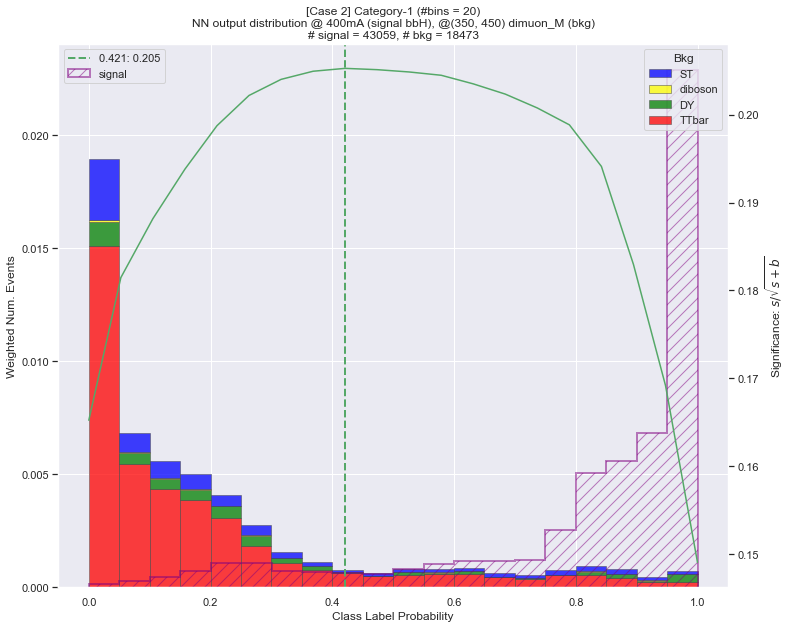

In [18]:
cmsplot(model, data, mass=400, category=1, case=2, signal='bbH')

See how it performs on case 1, too:

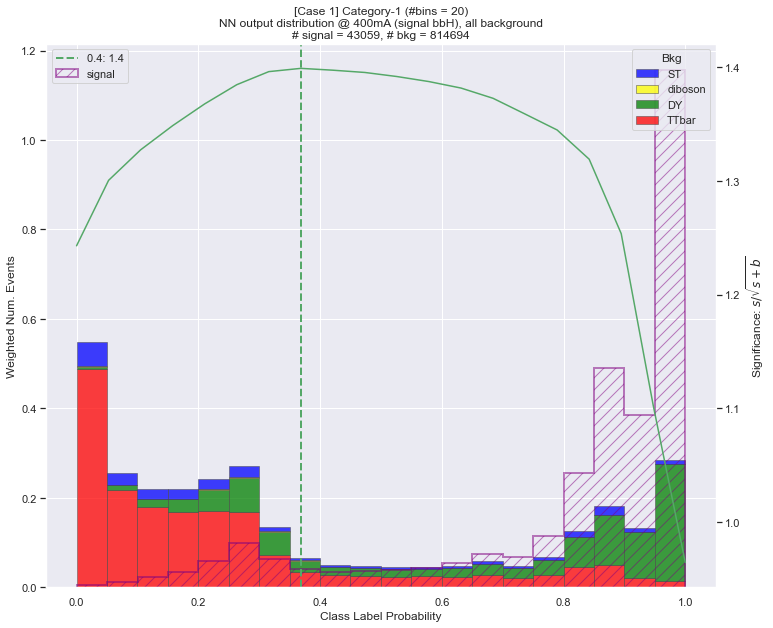

In [55]:
cmsplot(model, data, mass=400, category=1, case=1, signal='bbH')

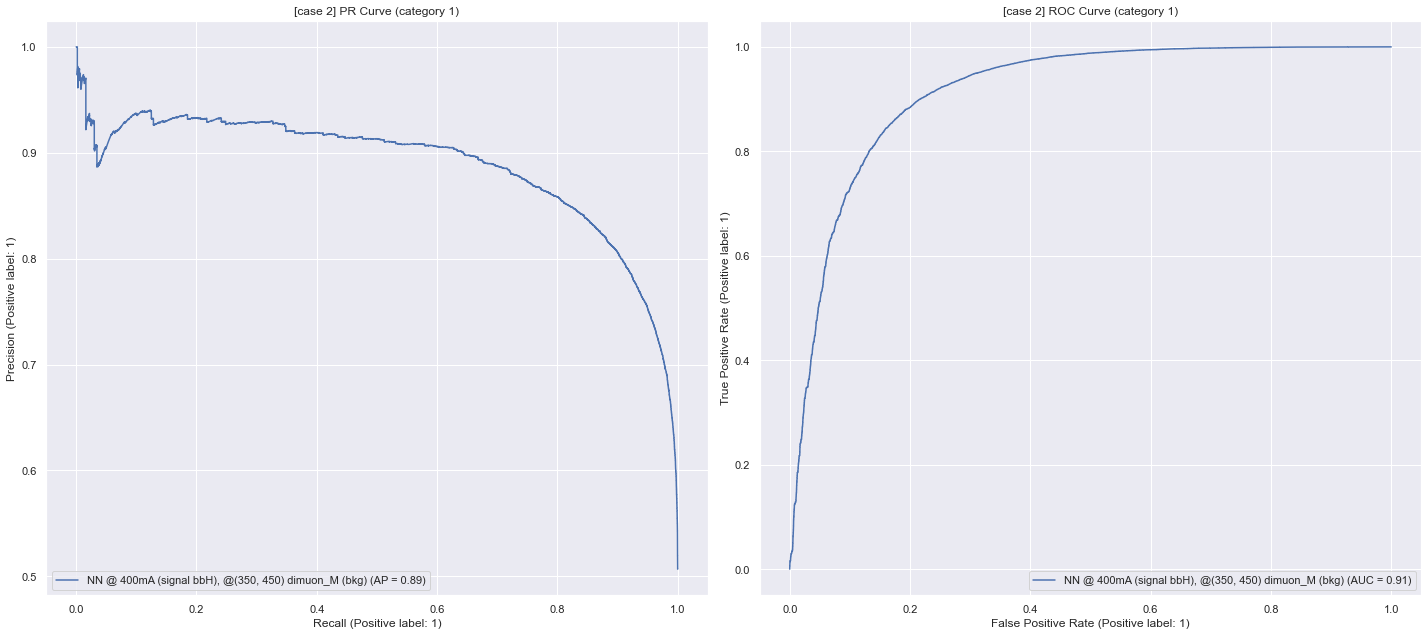

In [40]:
performance_plot(model1, data, mass=400, category=1, case=2, signal='bbH')

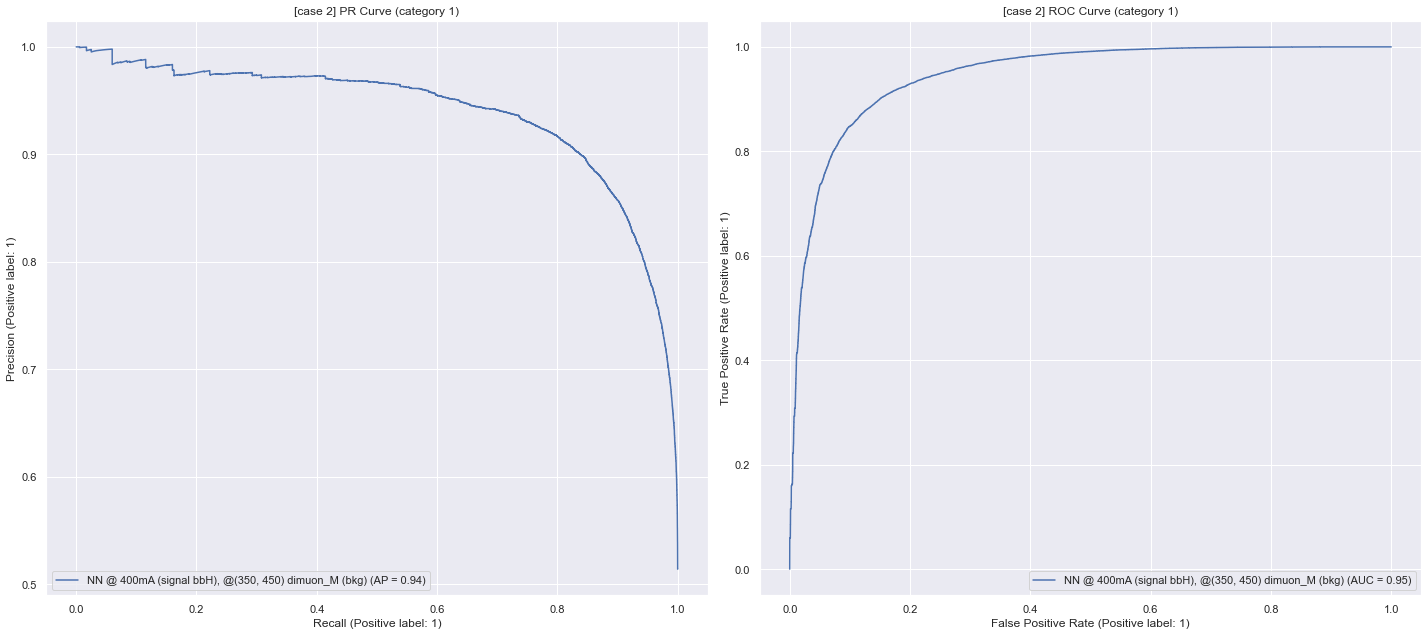

In [27]:
performance_plot(model2, data, mass=400, category=1, case=2, signal='bbH')

Comparison:

In [16]:
model1 = utils.get_compiled_non_parametric(data)
utils.load_from_checkpoint(model1, path='new/nn-400-bbH-cat_1-case_1')

model2 = utils.get_compiled_non_parametric(data, dropout=0.4)
utils.load_from_checkpoint(model2, path='new/nn-400-bbH-cat_1-case_2')

Loaded from "weights\new/nn-400-bbH-cat_1-case_1\weights-50-0.980"
Loaded from "weights\new/nn-400-bbH-cat_1-case_2\weights-60-0.960"


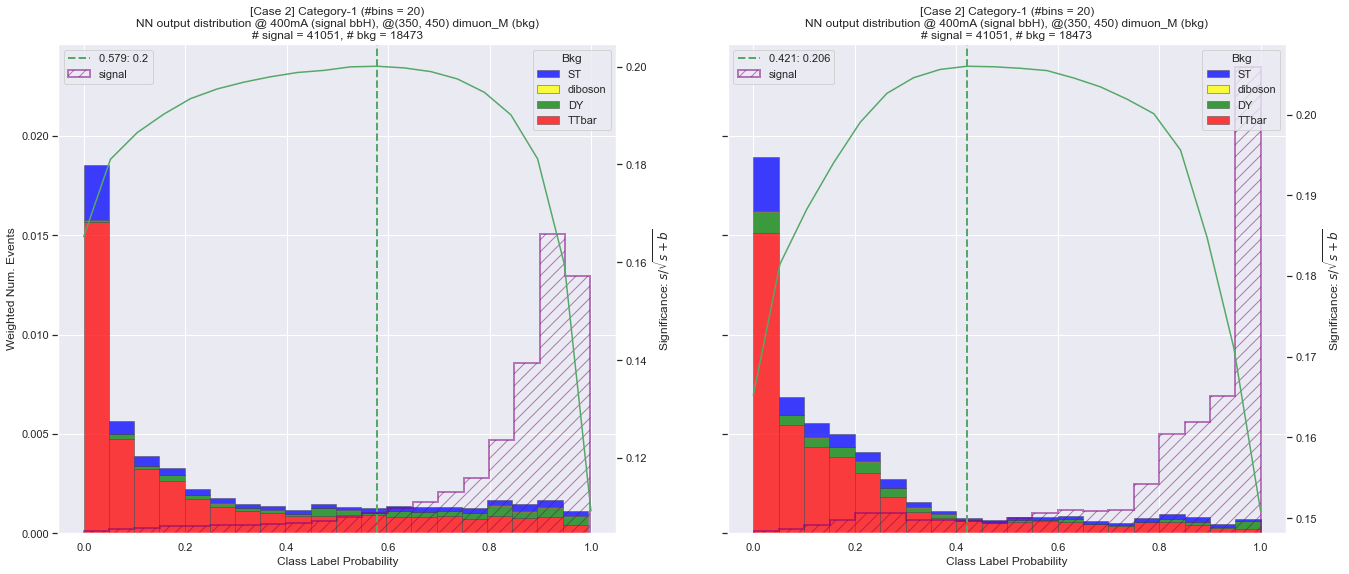

In [19]:
compare_significance([model1, model2], data, 400, category=1, signal='bbH', size=(11, 9), share_y=True,
                     path='plot/plot/category 1/bbH/performance/balanced', save='comparison_significance')

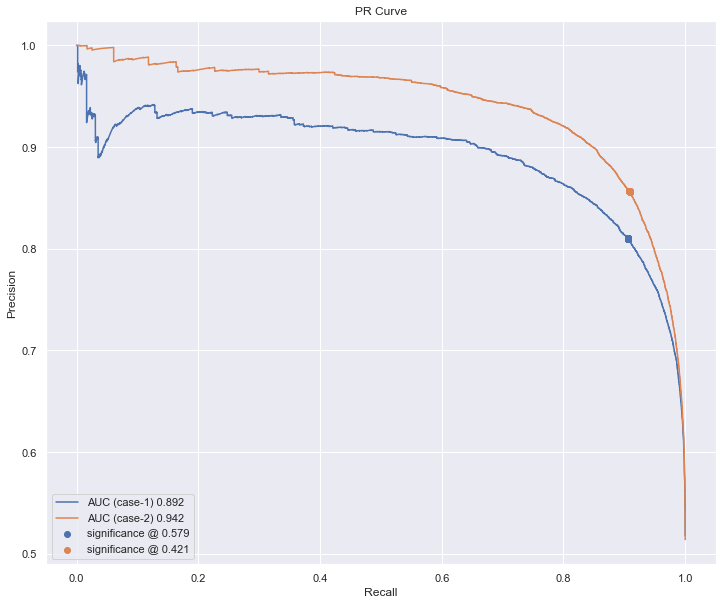

In [20]:
plot_pr(data, models_and_cuts={'case-1': (model1, 0.579), 'case-2': (model2, 0.421)},
        path='plot/plot/category 1/bbH/performance/balanced', save='precision_recall_curve')

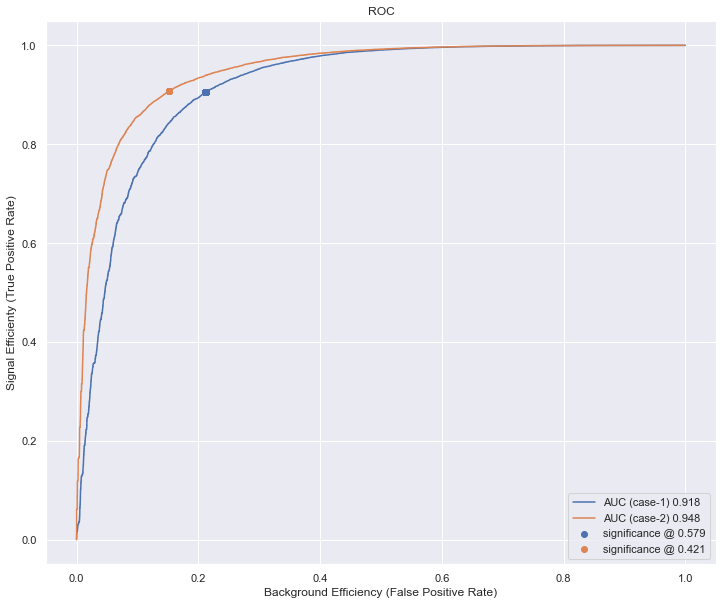

In [21]:
plot_roc(data, models_and_cuts={'case-1': (model1, 0.579), 'case-2': (model2, 0.421)},
         path='plot/plot/category 1/bbH/performance/balanced', save='ROC_curve')

Posterior Distribution of Variables:

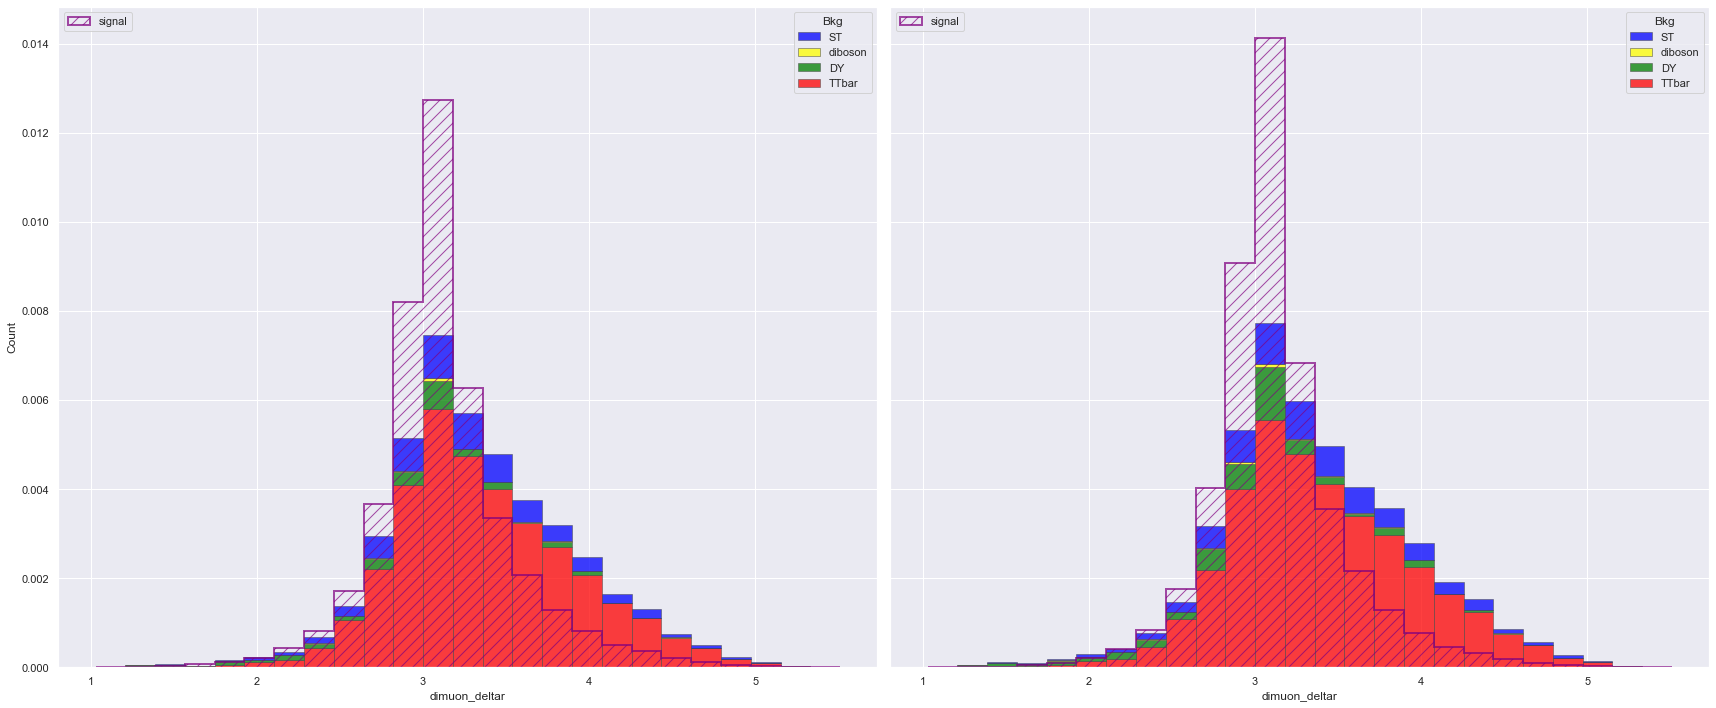

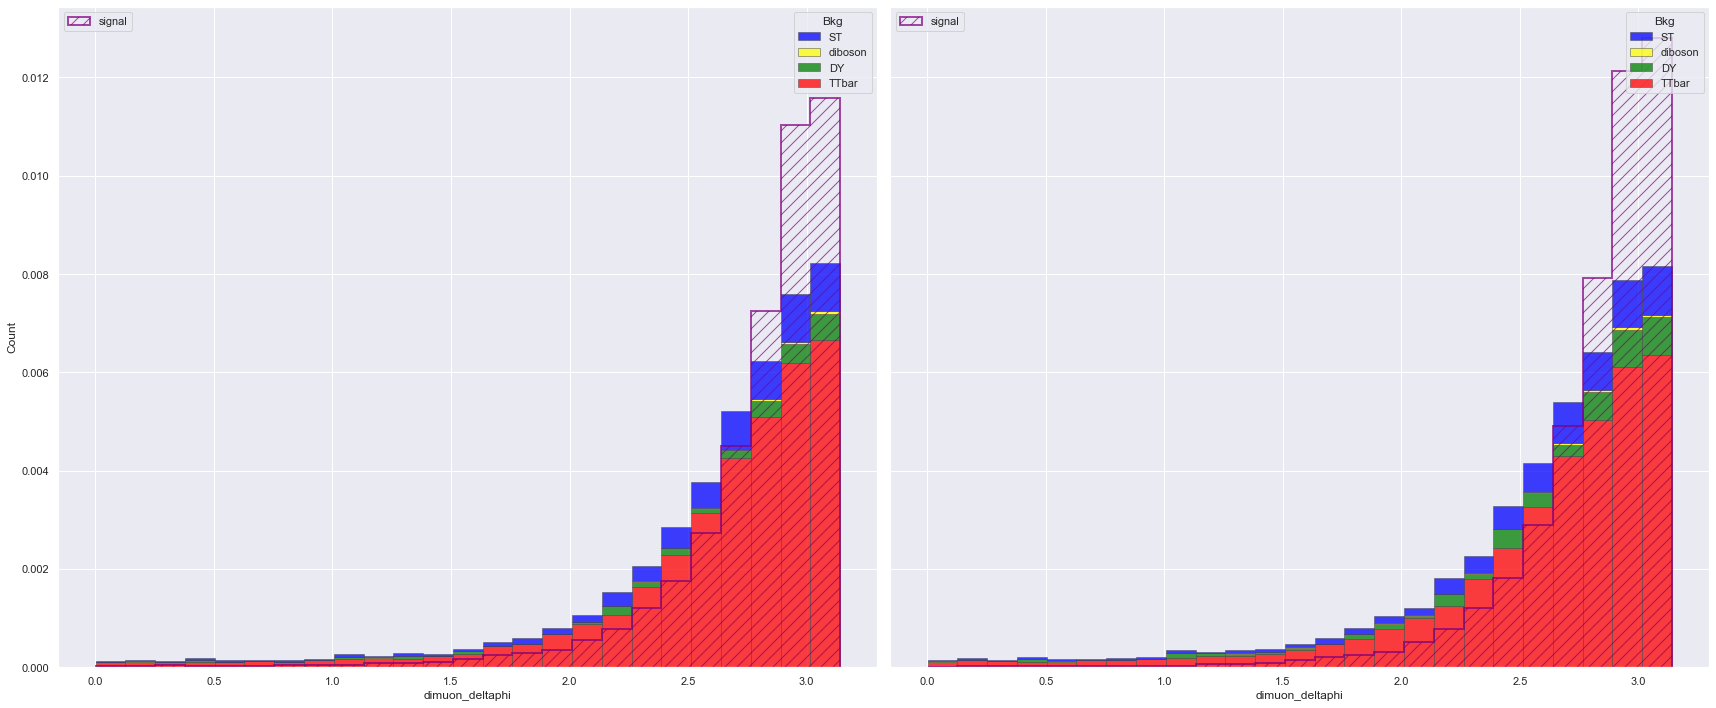

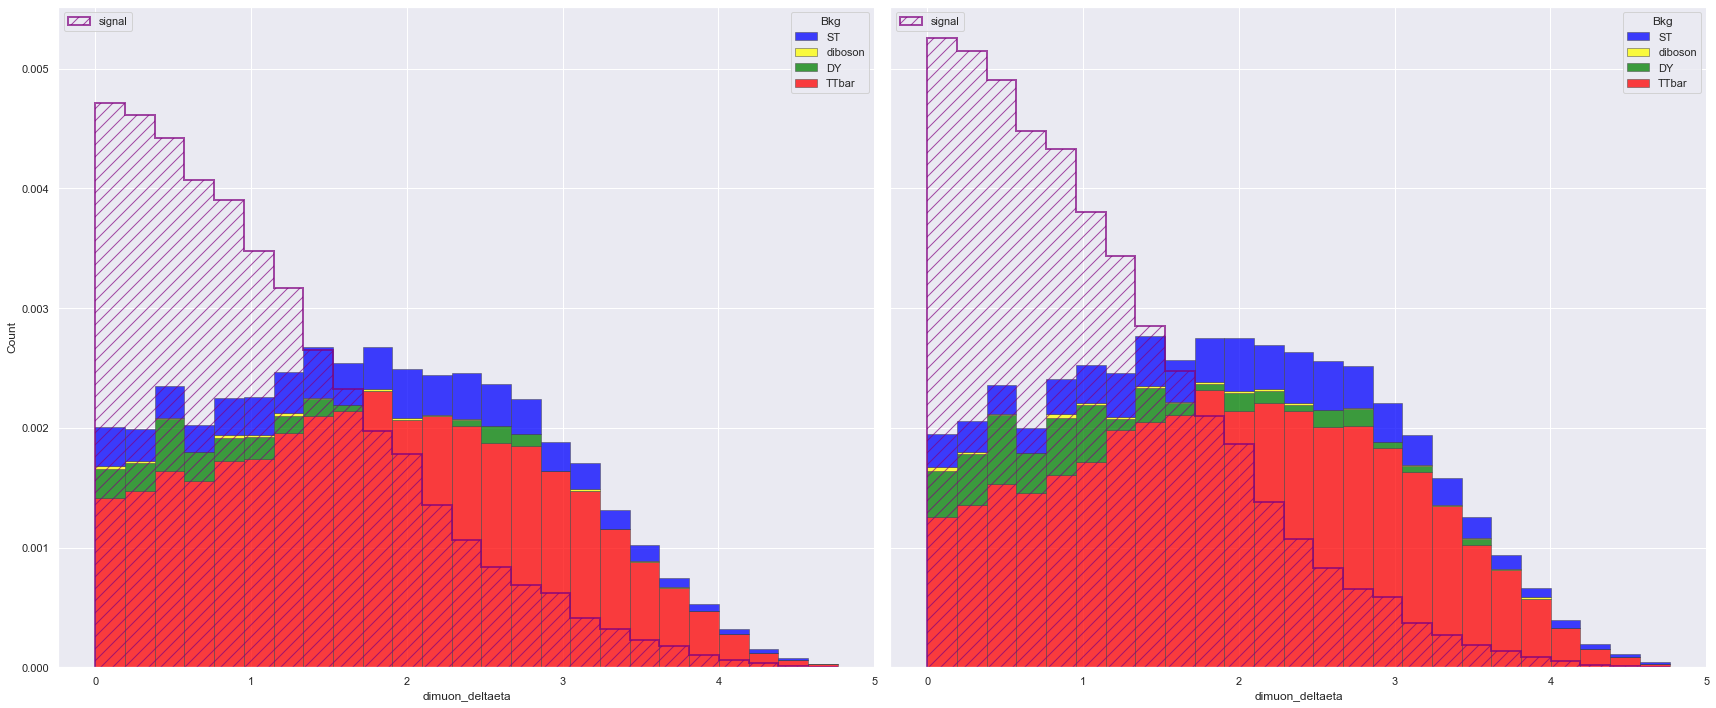

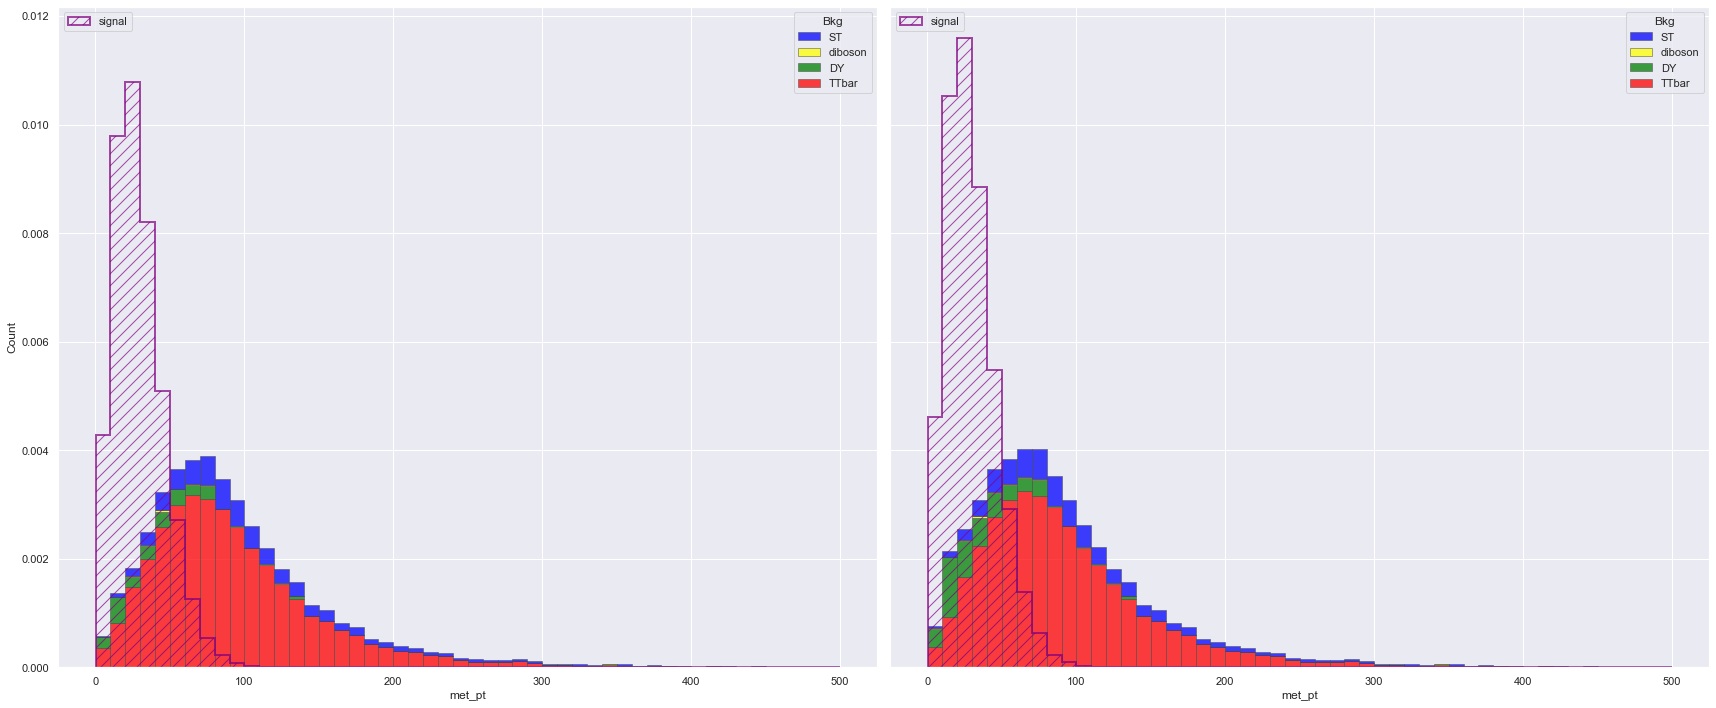

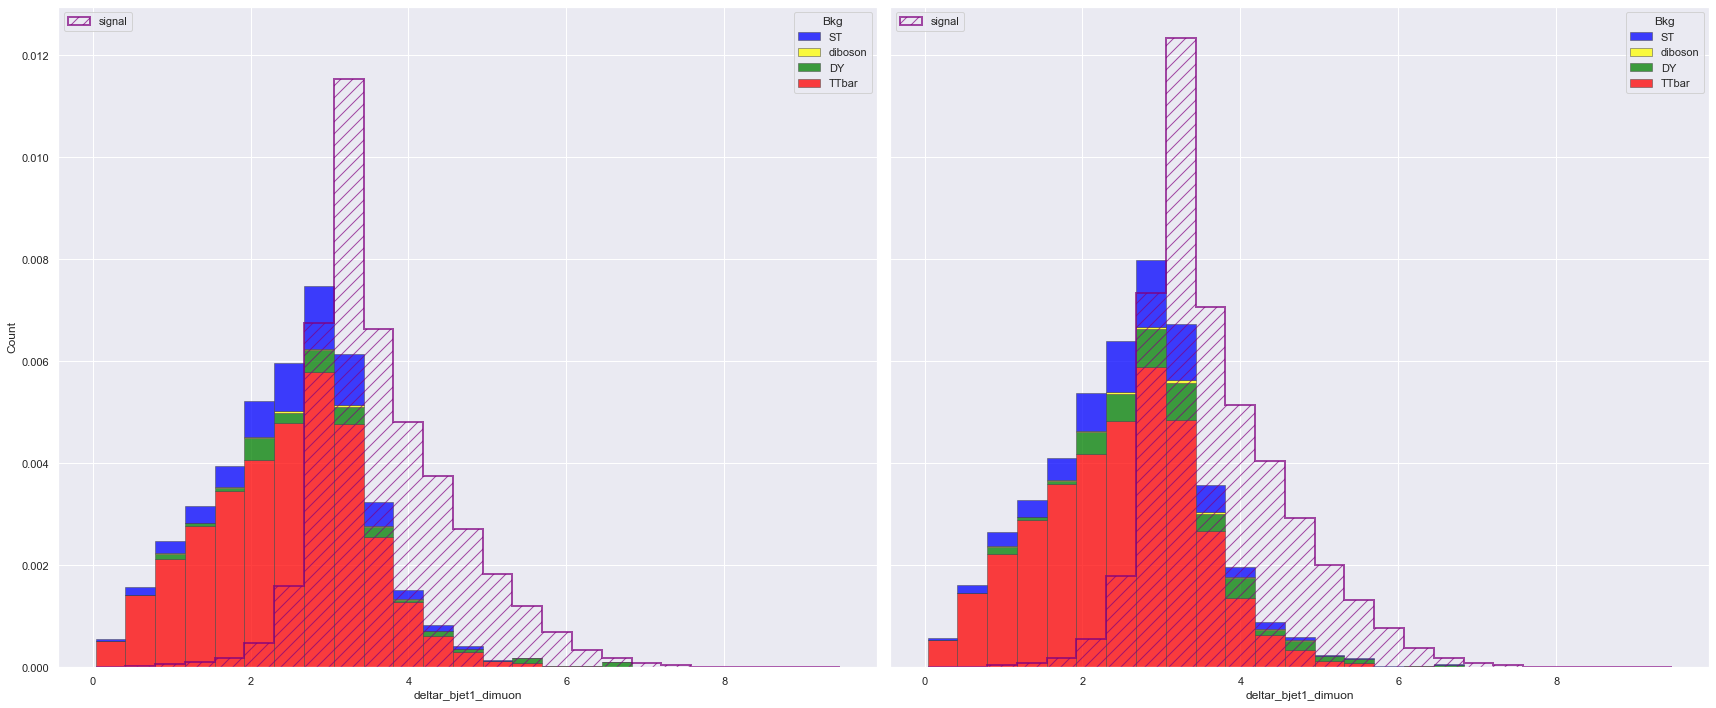

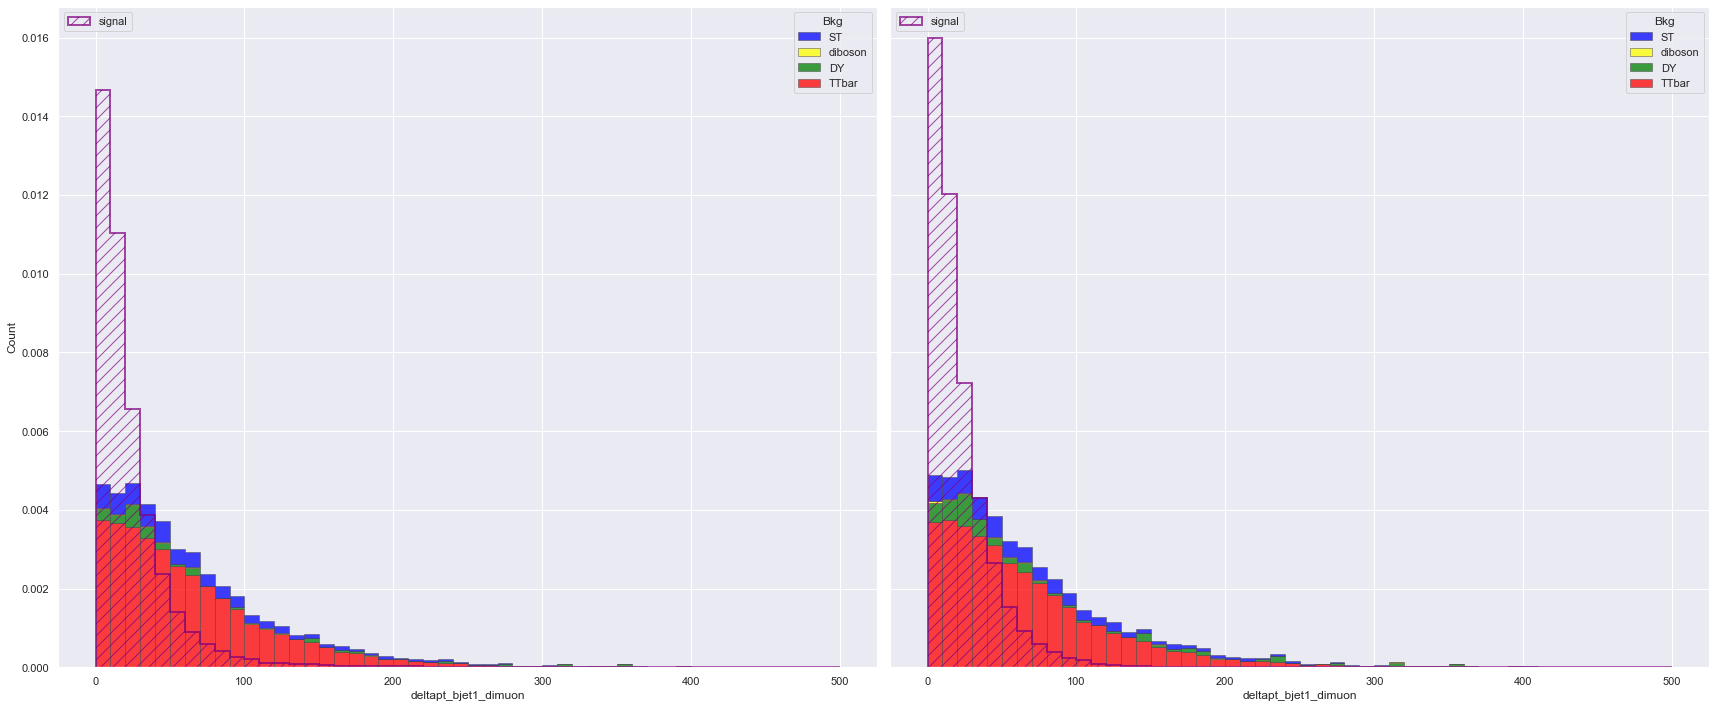

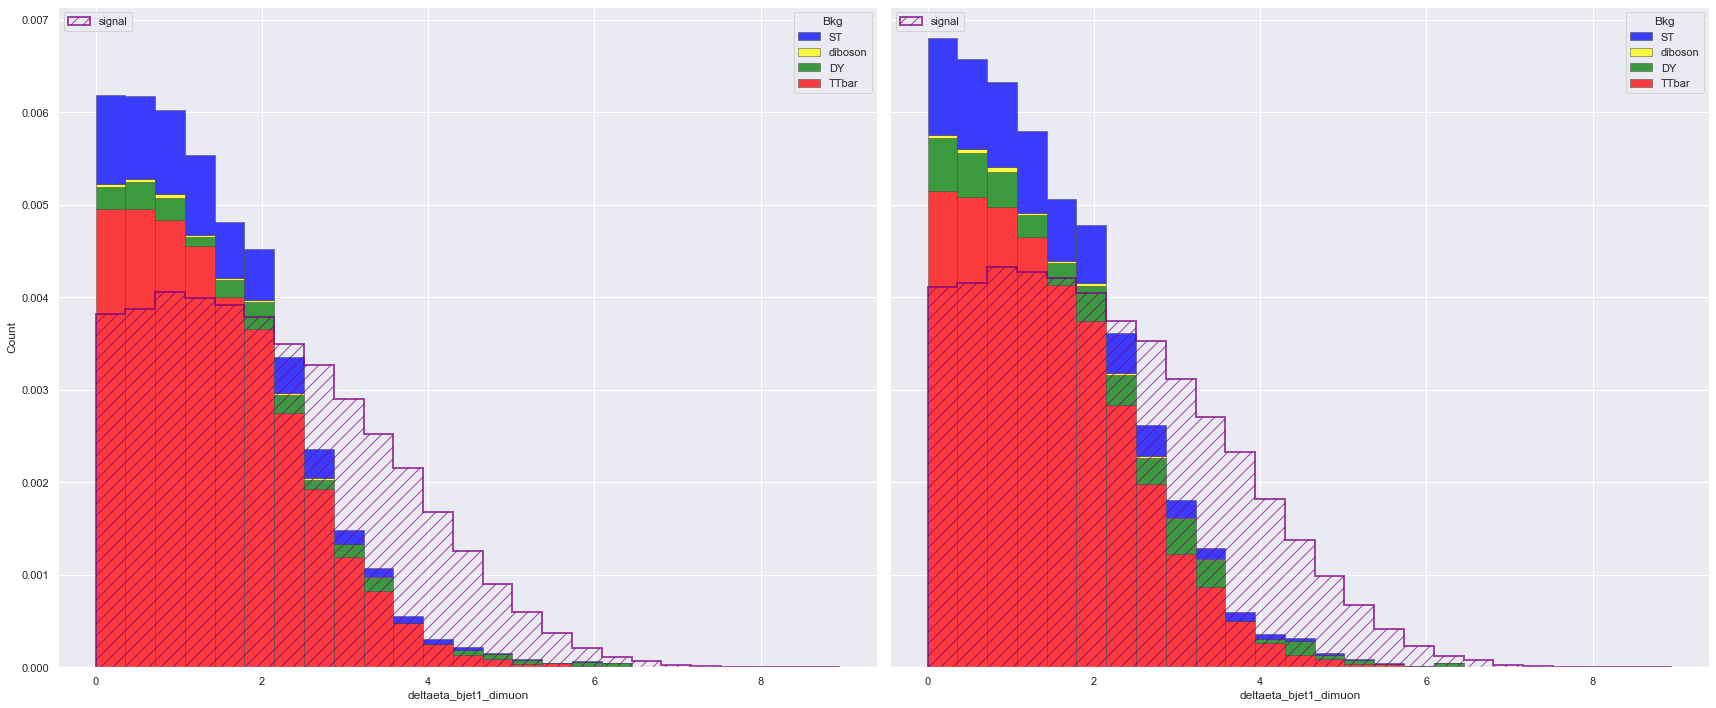

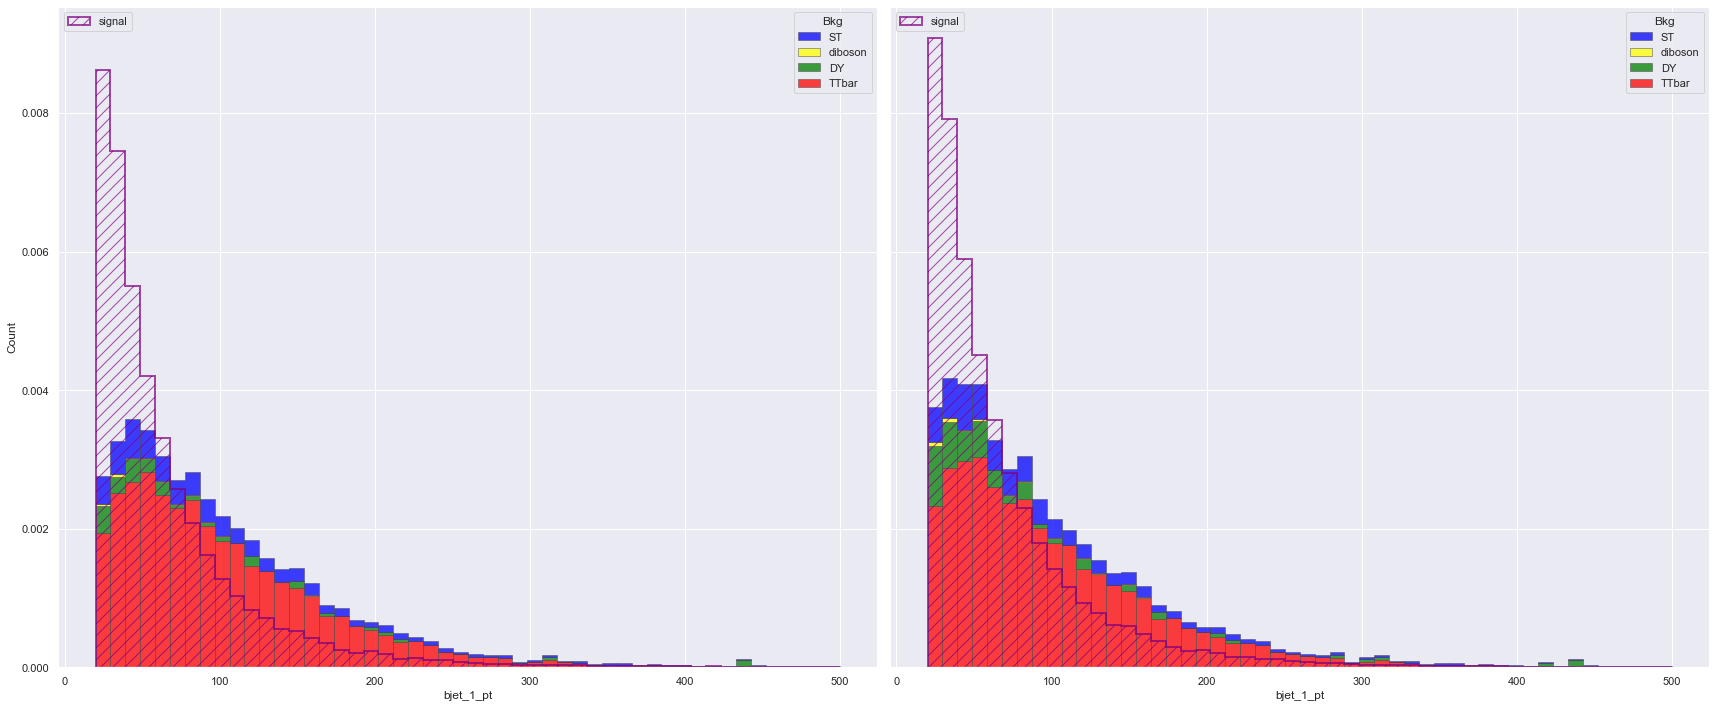

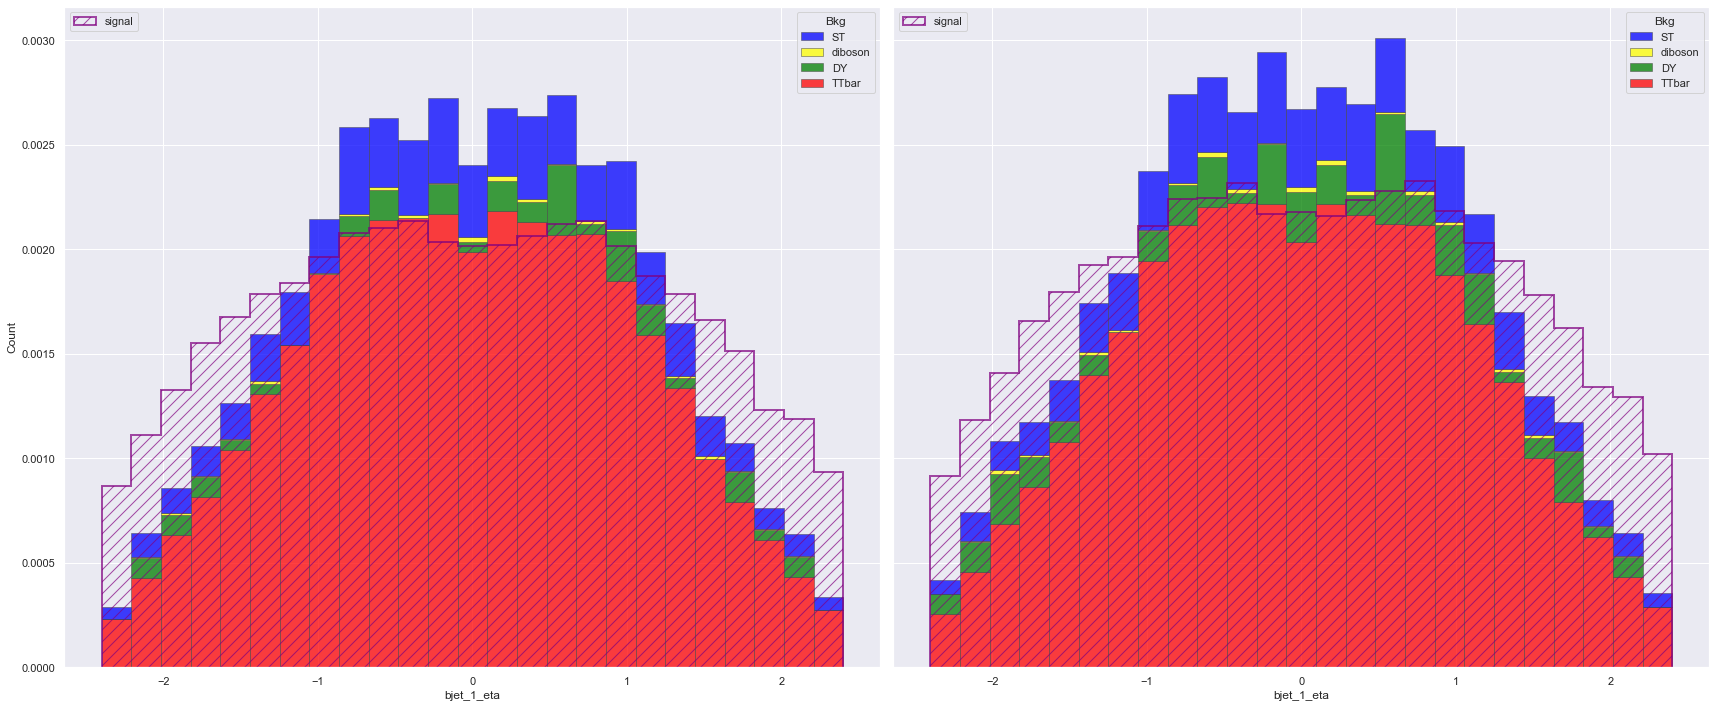

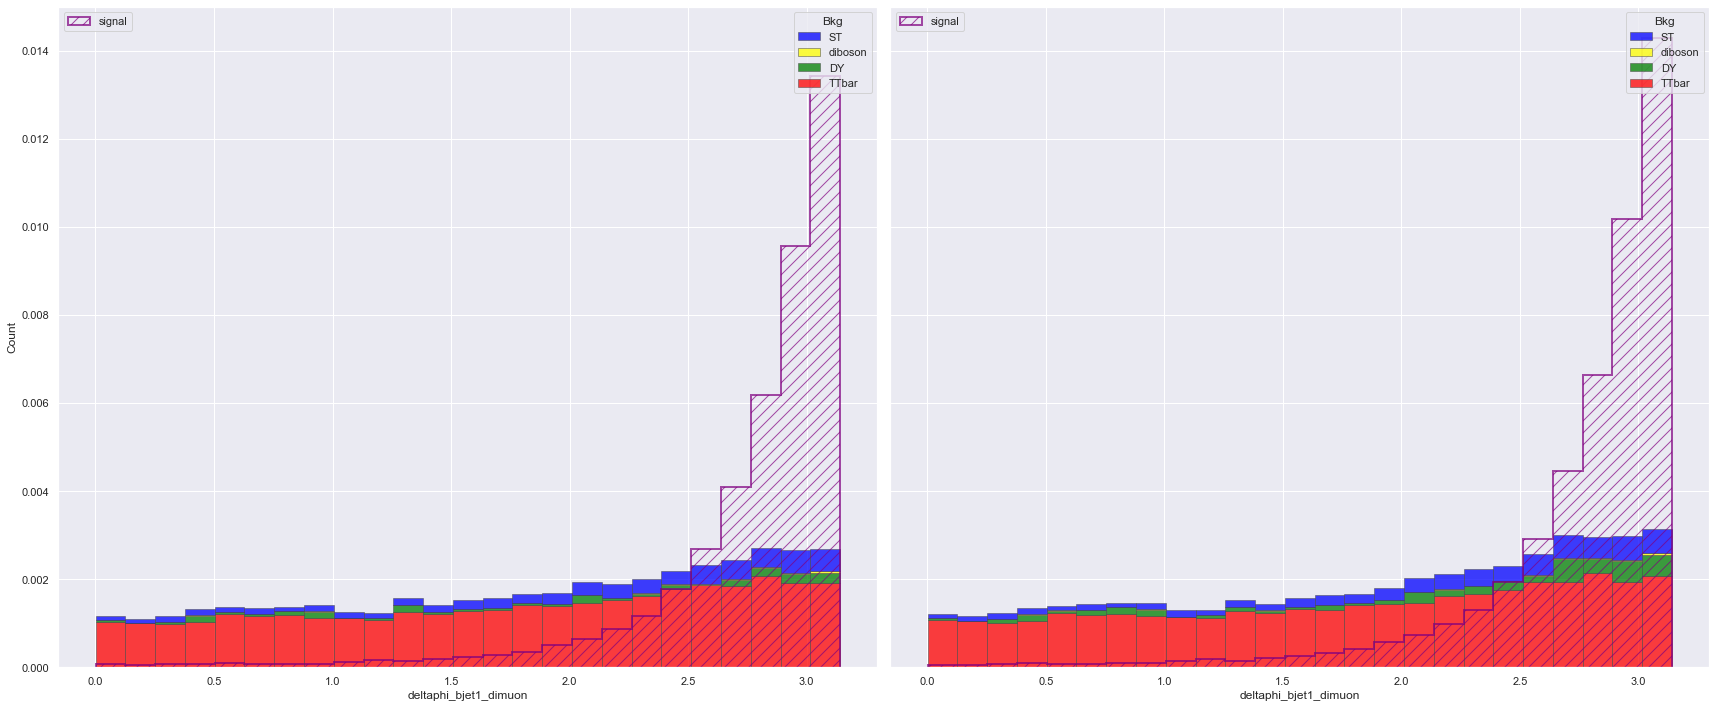

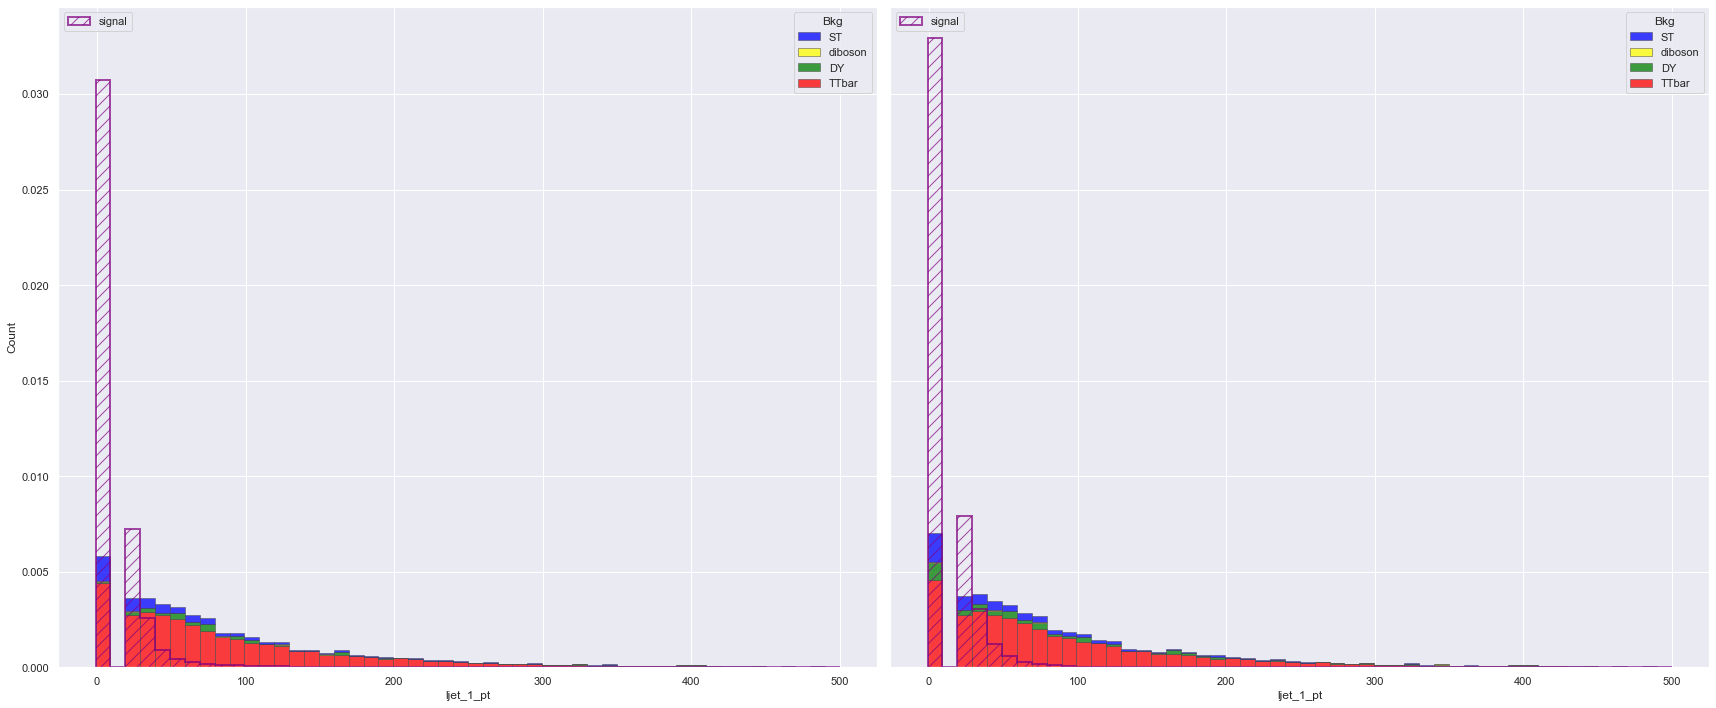

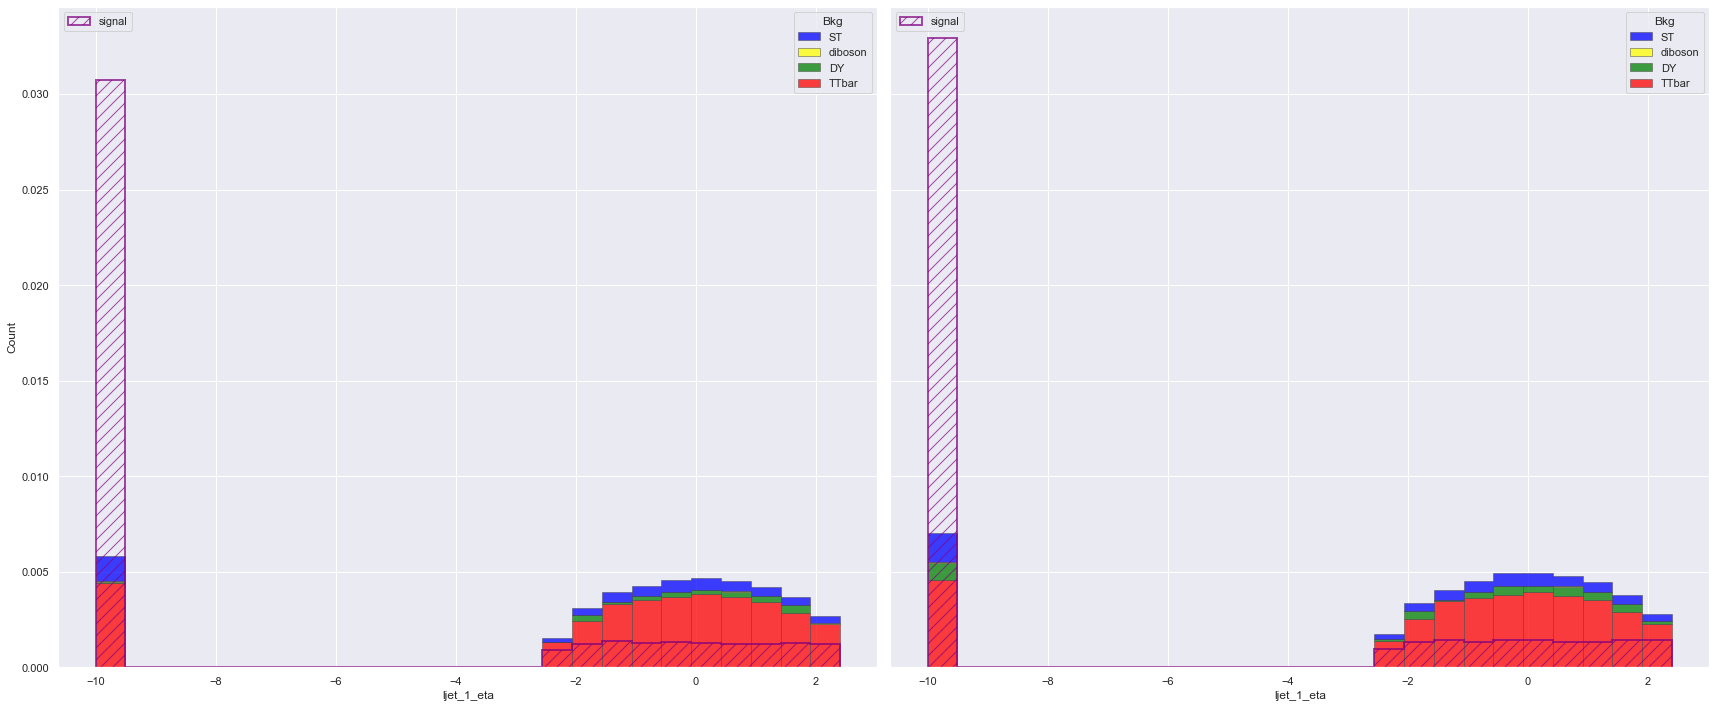

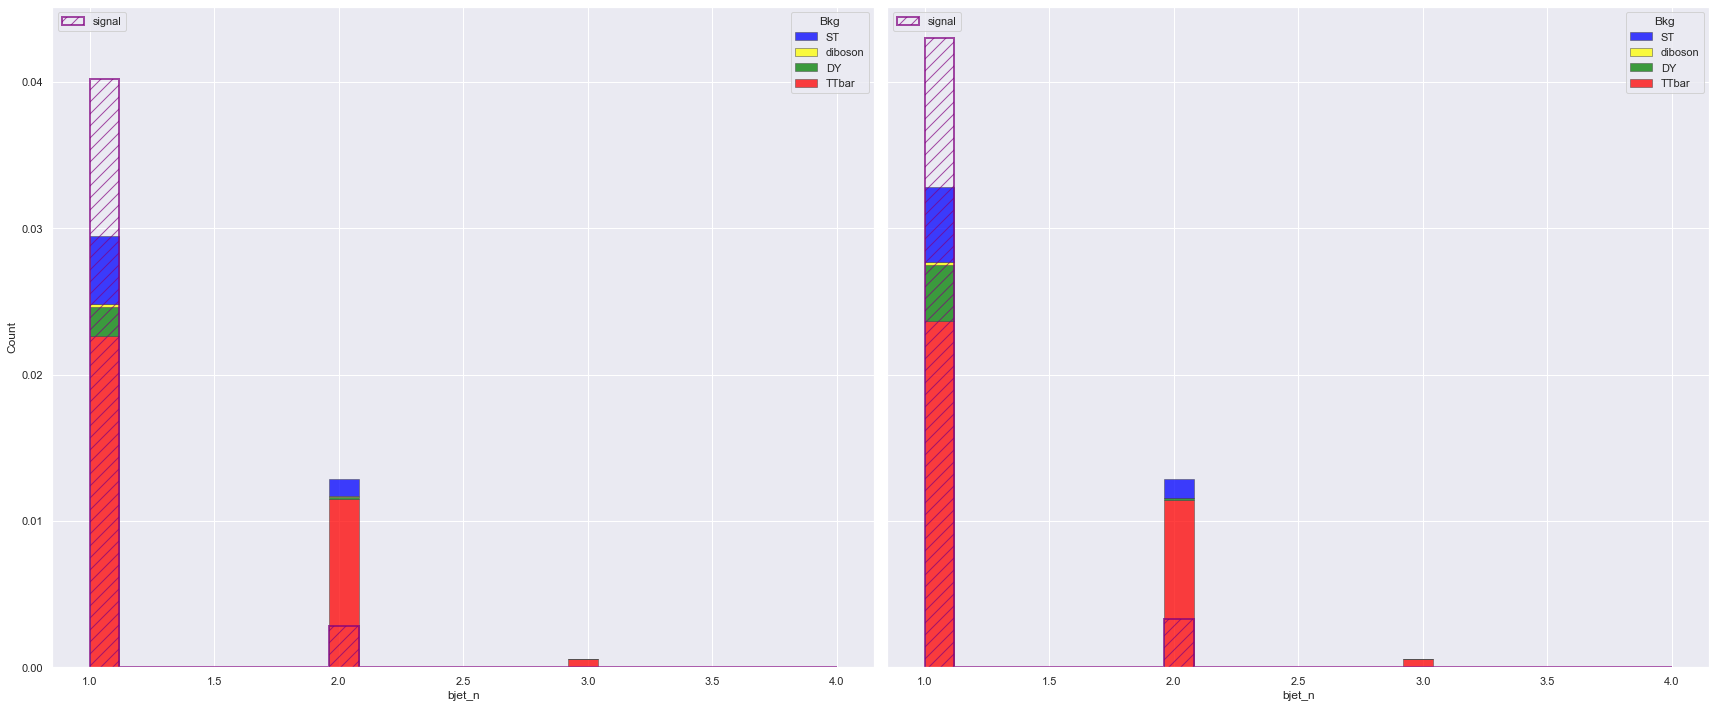

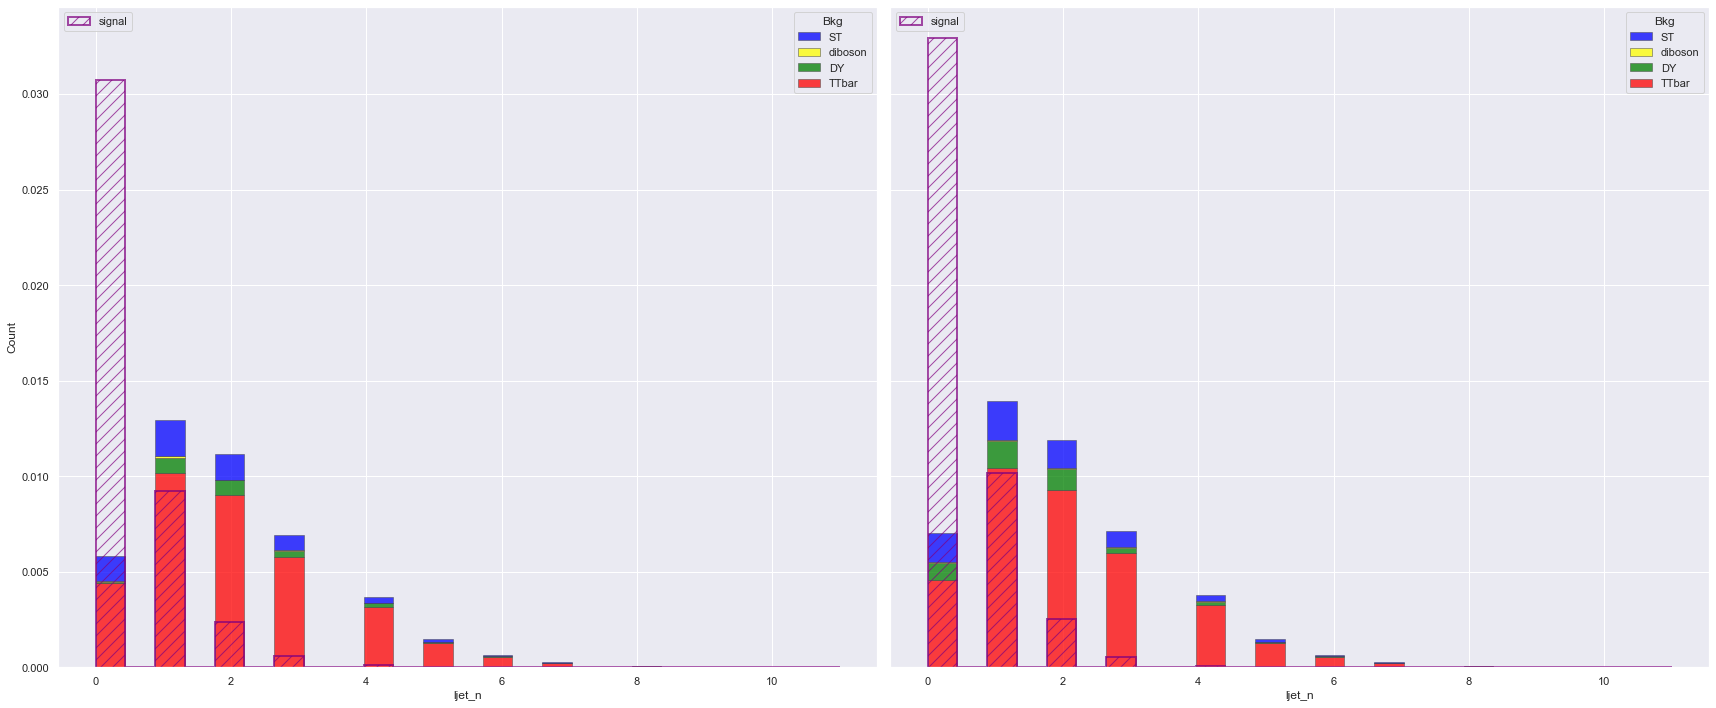

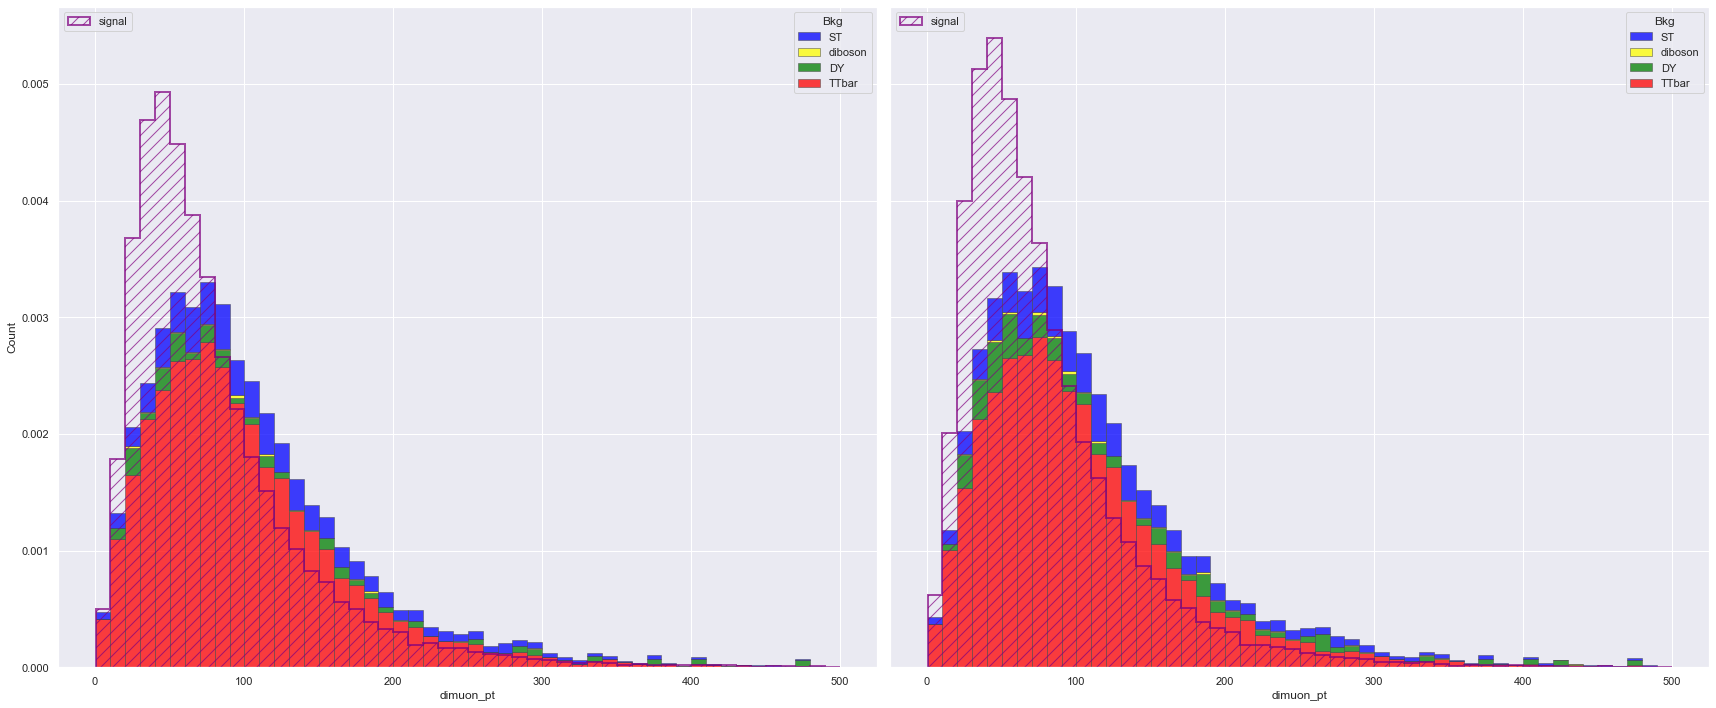

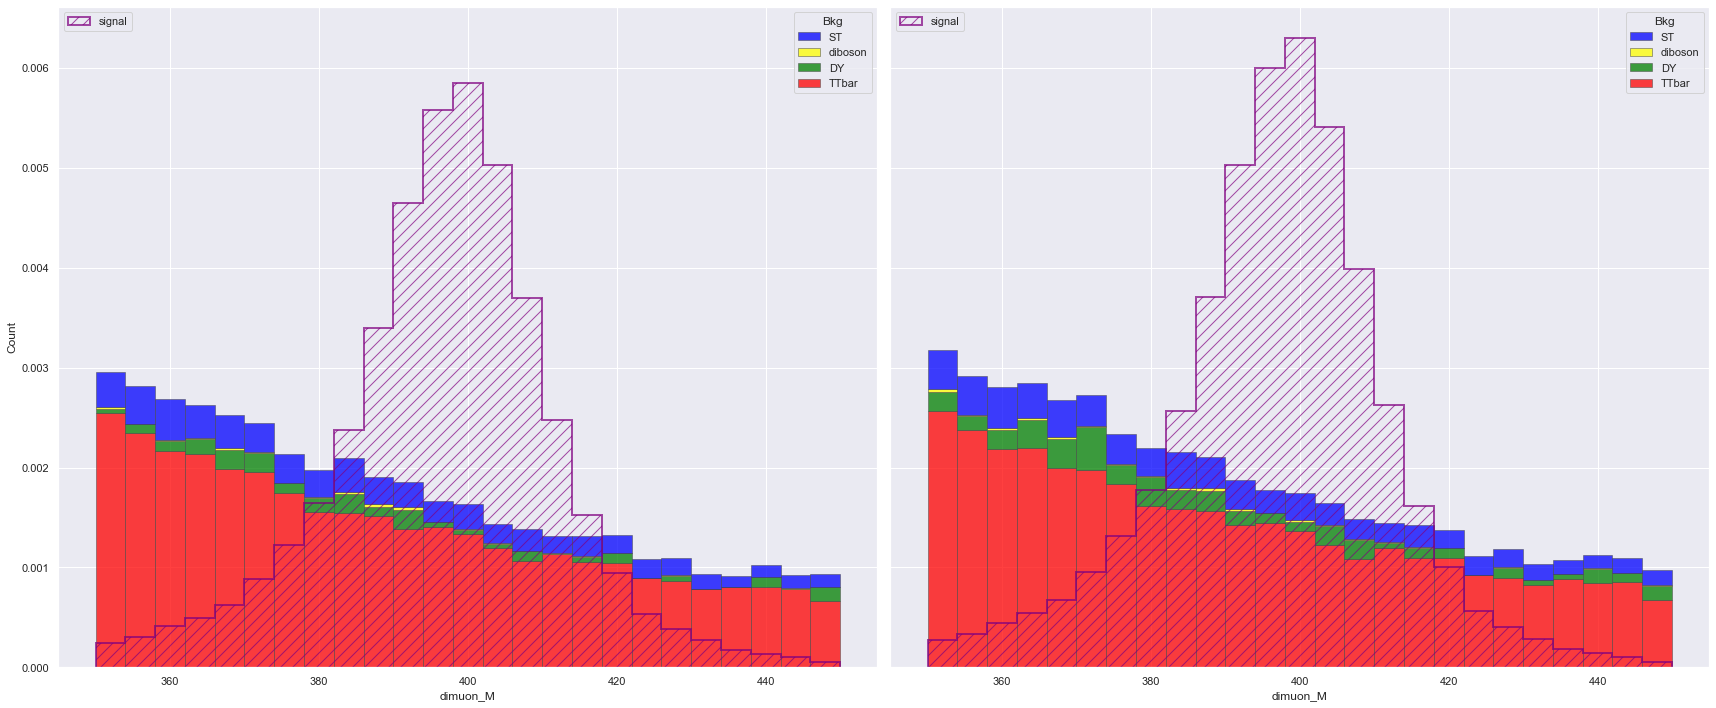

In [17]:
posteriori_plot2(data, models=(model1, model2), 
                variables=VAR_CAT1 + ['dimuon_pt', 'dimuon_M'], mass=400.0, 
                cuts=(0.579, 0.421), category=1, case=2, weight=True,
                path='plot/plot/category 1/bbH/performance/balanced', save='')

---

### Category 2

In [21]:
VAR_CAT2 = ["dimuon_deltar", "dimuon_deltaphi", "dimuon_deltaeta", "met_pt",
            "ljet_1_pt", "ljet_1_eta", "ljet_n"]

In [22]:
data = Dataset()
data.load(signal='data/new/signal_bassociated_cat2.csv', 
          bkg='data/new/background_cat2.csv', feature_columns=VAR_CAT2)

data.ds.loc[data.ds['ljet_1_eta'] == -10, 'ljet_1_eta'] = -3.0

[signal] loading...
[background] loading...
[Dataset] loaded.


In [32]:
# split data
train, valid, test = train_val_test_split(data)

#### Case 1

In [33]:
# create sequences
train_seq = BalancedSequence(signal=train[0], background=train[1], mass=400.0, category=2,
                             case=1, batch_size=128, features=VAR_CAT2)

valid_seq = BalancedSequence(signal=valid[0], background=valid[1], mass=400.0, category=2,
                             case=1, batch_size=1024, features=VAR_CAT2, balance=False)

test_seq = BalancedSequence(signal=test[0], background=test[1], mass=400.0, category=2,
                            case=1, batch_size=1024, features=VAR_CAT2, balance=False)

In [34]:
# create tf.Datasets
train_ds = dataset_from_sequence(train_seq)
valid_ds = dataset_from_sequence(valid_seq)
test_ds = dataset_from_sequence(test_seq)

In [64]:
# create model
model, checkpoint = utils.get_compiled_non_parametric(data, save='new/nn-400-bbH-cat_2-case_1')

In [36]:
model.fit(x=train_ds, epochs=100, validation_data=valid_ds, verbose=2,
          callbacks=[checkpoint, EarlyStopping(patience=40)])

Epoch 1/100
1089/1089 - 87s - loss: 0.4538 - binary_accuracy: 0.7894 - auc: 0.8577 - precision: 0.7580 - recall: 0.8502 - class-loss: 0.4622 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 3.1779 - weight-norm: 20.4323 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0000e+00 - val_loss: 0.3410 - val_binary_accuracy: 0.9141 - val_auc: 0.8530 - val_precision: 0.9744 - val_recall: 0.9336
Epoch 2/100
1089/1089 - 84s - loss: 0.4673 - binary_accuracy: 0.8110 - auc: 0.8799 - precision: 0.7797 - recall: 0.8670 - class-loss: 0.4258 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 3.0435 - weight-norm: 20.9828 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0000e+00 - val_loss: 0.4126 - val_binary_accuracy: 0.8522 - val_auc: 0.8585 - val_precision: 0.9810 - val_recall: 0.8601
Epoch 3/100
1089/1089 - 80s - loss: 0.3421 - binary_accuracy: 0.8157 - auc: 0.8827 - precision: 0.7863 - recall: 0.8672 - class-loss: 0.4193 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 2.9676 - weight-norm: 21.3901 -

1089/1089 - 58s - loss: 0.4714 - binary_accuracy: 0.8322 - auc: 0.8965 - precision: 0.7980 - recall: 0.8895 - class-loss: 0.3871 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 2.6827 - weight-norm: 27.1244 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0000e+00 - val_loss: 0.3553 - val_binary_accuracy: 0.8796 - val_auc: 0.8679 - val_precision: 0.9810 - val_recall: 0.8898
Epoch 23/100
1089/1089 - 53s - loss: 0.3805 - binary_accuracy: 0.8322 - auc: 0.8970 - precision: 0.7991 - recall: 0.8876 - class-loss: 0.3868 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 2.7062 - weight-norm: 27.3486 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0000e+00 - val_loss: 0.3863 - val_binary_accuracy: 0.8632 - val_auc: 0.8613 - val_precision: 0.9819 - val_recall: 0.8713
Epoch 24/100
1089/1089 - 53s - loss: 0.3907 - binary_accuracy: 0.8307 - auc: 0.8962 - precision: 0.7979 - recall: 0.8857 - class-loss: 0.3885 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 2.5927 - weight-norm: 27.5586 - adversari

Epoch 44/100
1089/1089 - 55s - loss: 0.3475 - binary_accuracy: 0.8328 - auc: 0.8982 - precision: 0.7998 - recall: 0.8878 - class-loss: 0.3849 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 2.4432 - weight-norm: 32.0553 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0000e+00 - val_loss: 0.3662 - val_binary_accuracy: 0.8783 - val_auc: 0.8771 - val_precision: 0.9817 - val_recall: 0.8878
Epoch 45/100
1089/1089 - 54s - loss: 0.4011 - binary_accuracy: 0.8346 - auc: 0.8990 - precision: 0.8021 - recall: 0.8885 - class-loss: 0.3830 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 2.4419 - weight-norm: 32.2202 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0000e+00 - val_loss: 0.3581 - val_binary_accuracy: 0.8796 - val_auc: 0.8840 - val_precision: 0.9831 - val_recall: 0.8878
Epoch 46/100
1089/1089 - 54s - loss: 0.4055 - binary_accuracy: 0.8340 - auc: 0.8981 - precision: 0.8002 - recall: 0.8901 - class-loss: 0.3834 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 2.4729 - weight-norm: 32.405

In [65]:
utils.load_from_checkpoint(model, path='new/nn-400-bbH-cat_2-case_1')

Loaded from "weights\new/nn-400-bbH-cat_2-case_1\weights-40-0.885"


In [38]:
model.evaluate(x=test_ds, verbose=2)

45/45 - 1s - loss: 0.3584 - binary_accuracy: 0.8689 - auc: 0.8535 - precision: 0.9801 - recall: 0.8790


[0.3583523631095886,
 0.8688806891441345,
 0.8534799218177795,
 0.9801103472709656,
 0.8790364861488342]

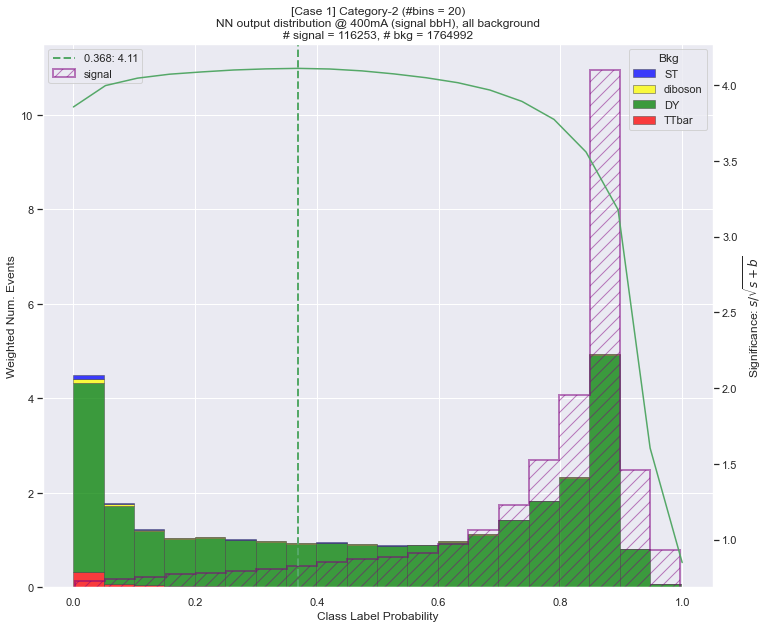

In [66]:
cmsplot(model, data, mass=400, category=2, case=1, signal='bbH')

See how it performs on case 2, too:

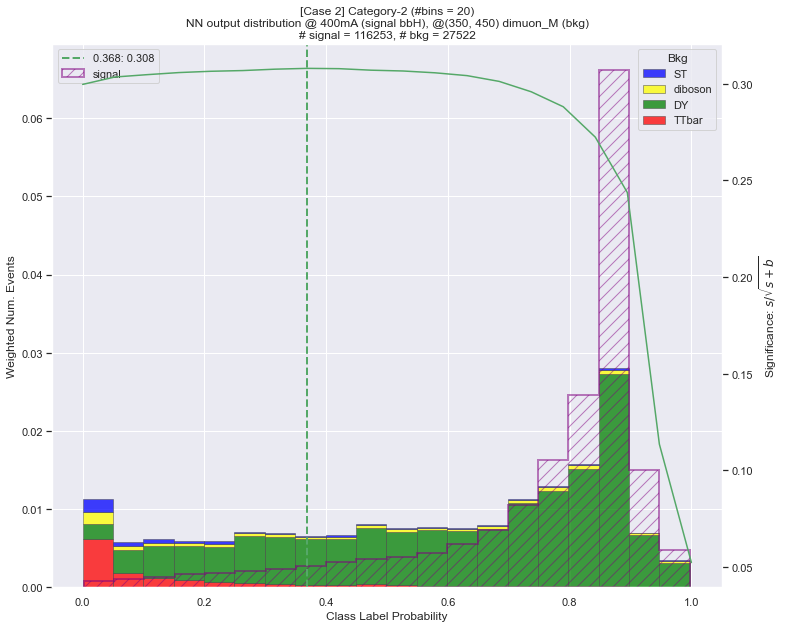

In [68]:
cmsplot(model, data, mass=400, category=2, case=2, signal='bbH')

#### Case 2

In [39]:
# create sequences
train_seq = BalancedSequence(signal=train[0], background=train[1], mass=400.0, category=2,
                             case=2, batch_size=128, features=VAR_CAT2)

valid_seq = BalancedSequence(signal=valid[0], background=valid[1], mass=400.0, category=2,
                             case=2, batch_size=1024, features=VAR_CAT2, balance=False)

test_seq = BalancedSequence(signal=test[0], background=test[1], mass=400.0, category=2,
                            case=2, batch_size=1024, features=VAR_CAT2, balance=False)

In [40]:
# create tf.Datasets
train_ds = dataset_from_sequence(train_seq)
valid_ds = dataset_from_sequence(valid_seq)
test_ds = dataset_from_sequence(test_seq)

In [69]:
# create model
model, checkpoint = utils.get_compiled_non_parametric(data, save='new/nn-400-bbH-cat_2-case_2')

In [42]:
model.fit(x=train_ds, epochs=100, validation_data=valid_ds, verbose=2,
          callbacks=[checkpoint, EarlyStopping(patience=40)])

Epoch 1/100
1089/1089 - 15s - loss: 0.4316 - binary_accuracy: 0.8052 - auc: 0.8734 - precision: 0.7911 - recall: 0.8293 - class-loss: 0.4385 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 1.7279 - weight-norm: 20.3319 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0000e+00 - val_loss: 0.4063 - val_binary_accuracy: 0.8497 - val_auc: 0.9026 - val_precision: 0.9873 - val_recall: 0.8518
Epoch 2/100
1089/1089 - 14s - loss: 0.4615 - binary_accuracy: 0.8165 - auc: 0.8842 - precision: 0.7942 - recall: 0.8544 - class-loss: 0.4162 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 1.0318 - weight-norm: 20.7582 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0000e+00 - val_loss: 0.3752 - val_binary_accuracy: 0.8592 - val_auc: 0.9046 - val_precision: 0.9881 - val_recall: 0.8613
Epoch 3/100
1089/1089 - 14s - loss: 0.4712 - binary_accuracy: 0.8167 - auc: 0.8845 - precision: 0.7920 - recall: 0.8590 - class-loss: 0.4162 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 0.8519 - weight-norm: 21.0846 -

1089/1089 - 14s - loss: 0.3353 - binary_accuracy: 0.8231 - auc: 0.8923 - precision: 0.7931 - recall: 0.8742 - class-loss: 0.4003 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 1.1766 - weight-norm: 30.6080 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0000e+00 - val_loss: 0.4113 - val_binary_accuracy: 0.8601 - val_auc: 0.9085 - val_precision: 0.9866 - val_recall: 0.8637
Epoch 23/100
1089/1089 - 13s - loss: 0.3772 - binary_accuracy: 0.8236 - auc: 0.8921 - precision: 0.7935 - recall: 0.8750 - class-loss: 0.4009 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 1.1771 - weight-norm: 31.0779 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0000e+00 - val_loss: 0.3759 - val_binary_accuracy: 0.8760 - val_auc: 0.8990 - val_precision: 0.9858 - val_recall: 0.8814
Epoch 24/100
1089/1089 - 14s - loss: 0.4161 - binary_accuracy: 0.8229 - auc: 0.8925 - precision: 0.7942 - recall: 0.8715 - class-loss: 0.4011 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 1.1916 - weight-norm: 31.5556 - adversari

Epoch 44/100
1089/1089 - 13s - loss: 0.2929 - binary_accuracy: 0.8302 - auc: 0.8998 - precision: 0.8082 - recall: 0.8660 - class-loss: 0.3890 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 1.5396 - weight-norm: 40.9662 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0000e+00 - val_loss: 0.3556 - val_binary_accuracy: 0.8522 - val_auc: 0.9052 - val_precision: 0.9869 - val_recall: 0.8549
Epoch 45/100
1089/1089 - 13s - loss: 0.3479 - binary_accuracy: 0.8299 - auc: 0.8993 - precision: 0.8075 - recall: 0.8662 - class-loss: 0.3903 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 1.5232 - weight-norm: 41.4127 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0000e+00 - val_loss: 0.3652 - val_binary_accuracy: 0.8706 - val_auc: 0.8850 - val_precision: 0.9850 - val_recall: 0.8763
Epoch 46/100
1089/1089 - 13s - loss: 0.3439 - binary_accuracy: 0.8325 - auc: 0.9005 - precision: 0.8094 - recall: 0.8698 - class-loss: 0.3870 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 1.5799 - weight-norm: 41.841

1089/1089 - 14s - loss: 0.3698 - binary_accuracy: 0.8391 - auc: 0.9081 - precision: 0.8193 - recall: 0.8701 - class-loss: 0.3752 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 2.0131 - weight-norm: 49.8243 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0000e+00 - val_loss: 0.3594 - val_binary_accuracy: 0.8568 - val_auc: 0.8980 - val_precision: 0.9859 - val_recall: 0.8607
Epoch 66/100
1089/1089 - 14s - loss: 0.3201 - binary_accuracy: 0.8377 - auc: 0.9064 - precision: 0.8186 - recall: 0.8677 - class-loss: 0.3774 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 2.0324 - weight-norm: 50.2312 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0000e+00 - val_loss: 0.3642 - val_binary_accuracy: 0.8595 - val_auc: 0.8906 - val_precision: 0.9867 - val_recall: 0.8629
Epoch 67/100
1089/1089 - 14s - loss: 0.3591 - binary_accuracy: 0.8410 - auc: 0.9096 - precision: 0.8222 - recall: 0.8700 - class-loss: 0.3715 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 2.0188 - weight-norm: 50.6172 - adversari

In [70]:
utils.load_from_checkpoint(model, path='new/nn-400-bbH-cat_2-case_2')

Loaded from "weights\new/nn-400-bbH-cat_2-case_2\weights-18-0.916"


In [44]:
model.evaluate(x=test_ds, verbose=2)

45/45 - 0s - loss: 0.3615 - binary_accuracy: 0.8743 - auc: 0.8975 - precision: 0.9849 - recall: 0.8804


[0.36151447892189026,
 0.8742517232894897,
 0.8975457549095154,
 0.984852135181427,
 0.8804253339767456]

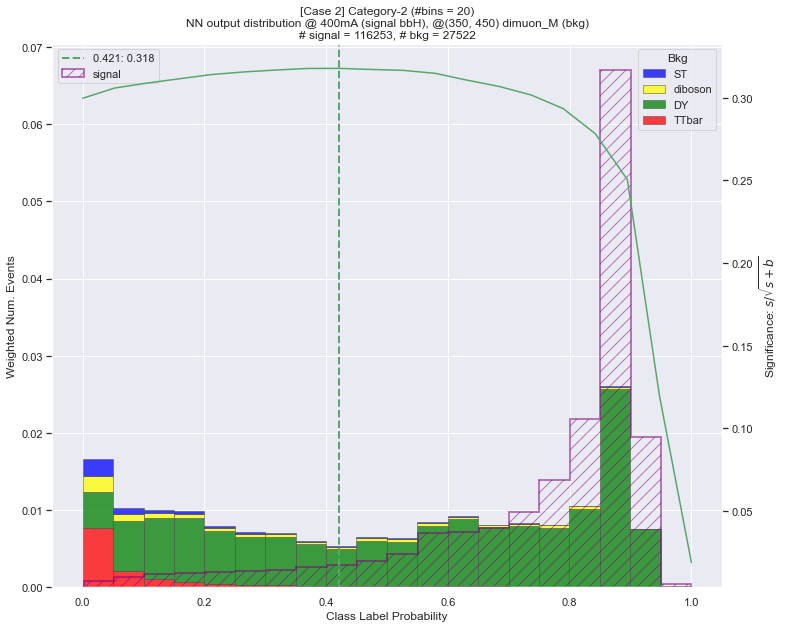

In [71]:
cmsplot(model, data, mass=400, category=2, case=2, signal='bbH')

See how it performs on case 1, too:

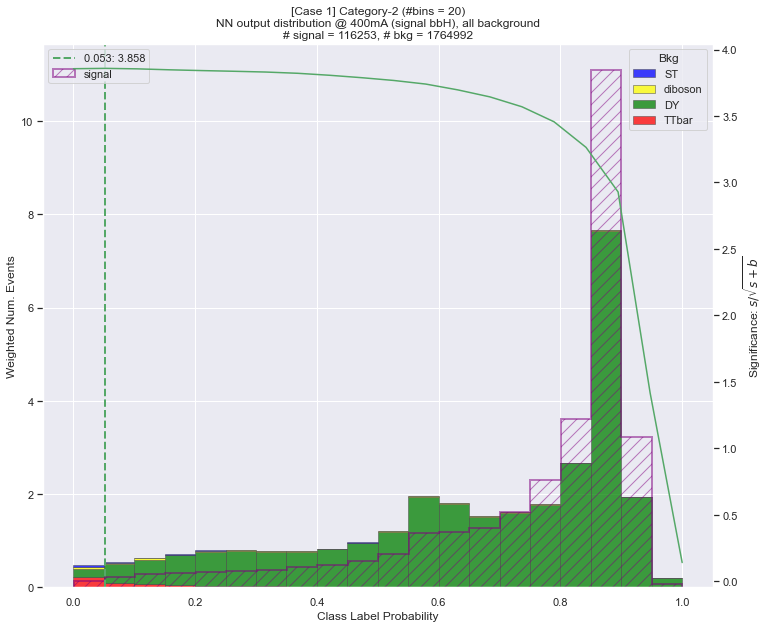

In [72]:
cmsplot(model, data, mass=400, category=2, case=1, signal='bbH')

In [23]:
model1 = utils.get_compiled_non_parametric(data)
utils.load_from_checkpoint(model1, path='new/nn-400-bbH-cat_2-case_1')

model2 = utils.get_compiled_non_parametric(data)
utils.load_from_checkpoint(model2, path='new/nn-400-bbH-cat_2-case_2')

Loaded from "weights\new/nn-400-bbH-cat_2-case_1\weights-40-0.885"
Loaded from "weights\new/nn-400-bbH-cat_2-case_2\weights-18-0.916"


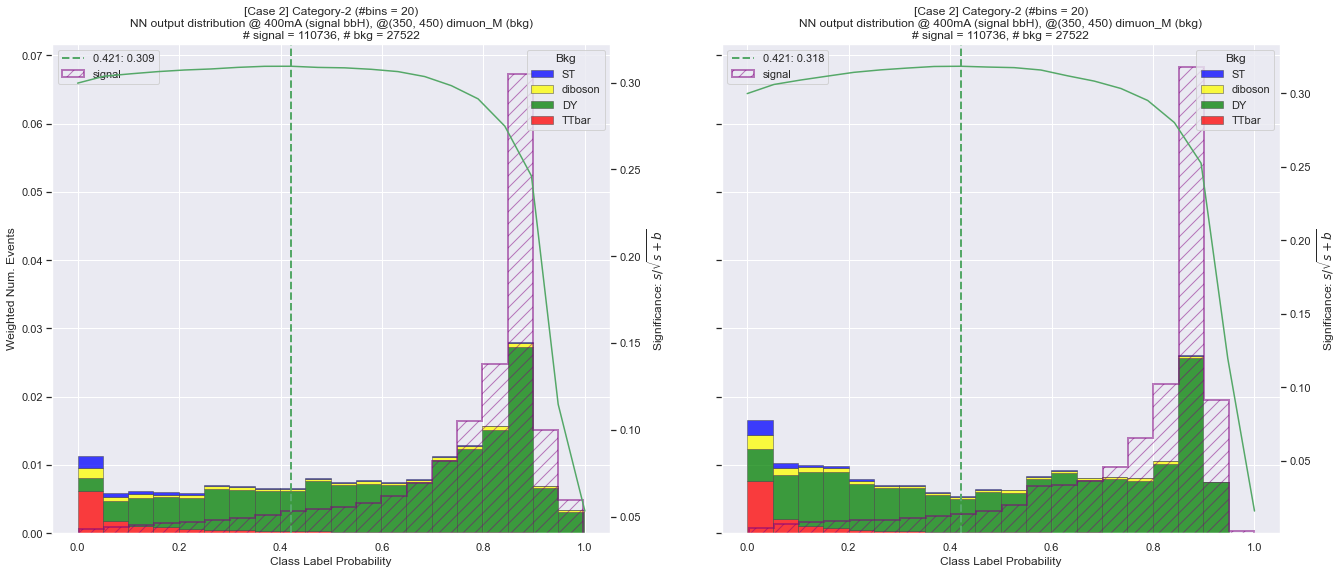

In [26]:
compare_significance([model1, model2], data, 400, category=2, signal='bbH', size=(11, 9), share_y=True,
                     path='plot/plot/category 2/bbH/performance/balanced', save='comparison_significance')

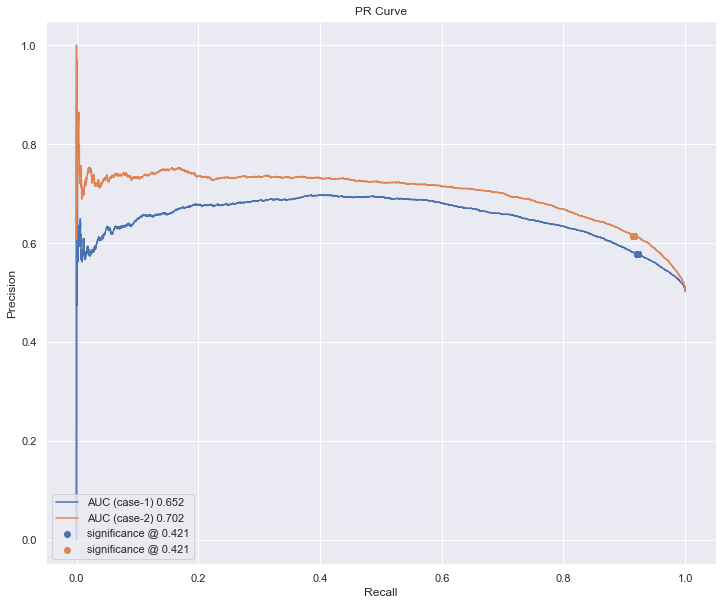

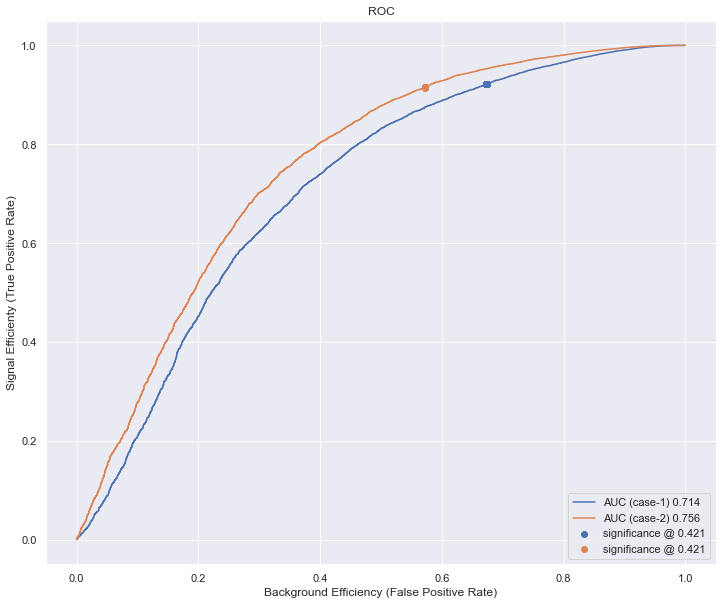

In [27]:
plot_pr(data, models_and_cuts={'case-1': (model1, 0.421), 'case-2': (model2, 0.421)},
        path='plot/plot/category 2/bbH/performance/balanced', save='precision_recall_curve')

plot_roc(data, models_and_cuts={'case-1': (model1, 0.421), 'case-2': (model2, 0.421)},
         path='plot/plot/category 2/bbH/performance/balanced', save='ROC_curve')

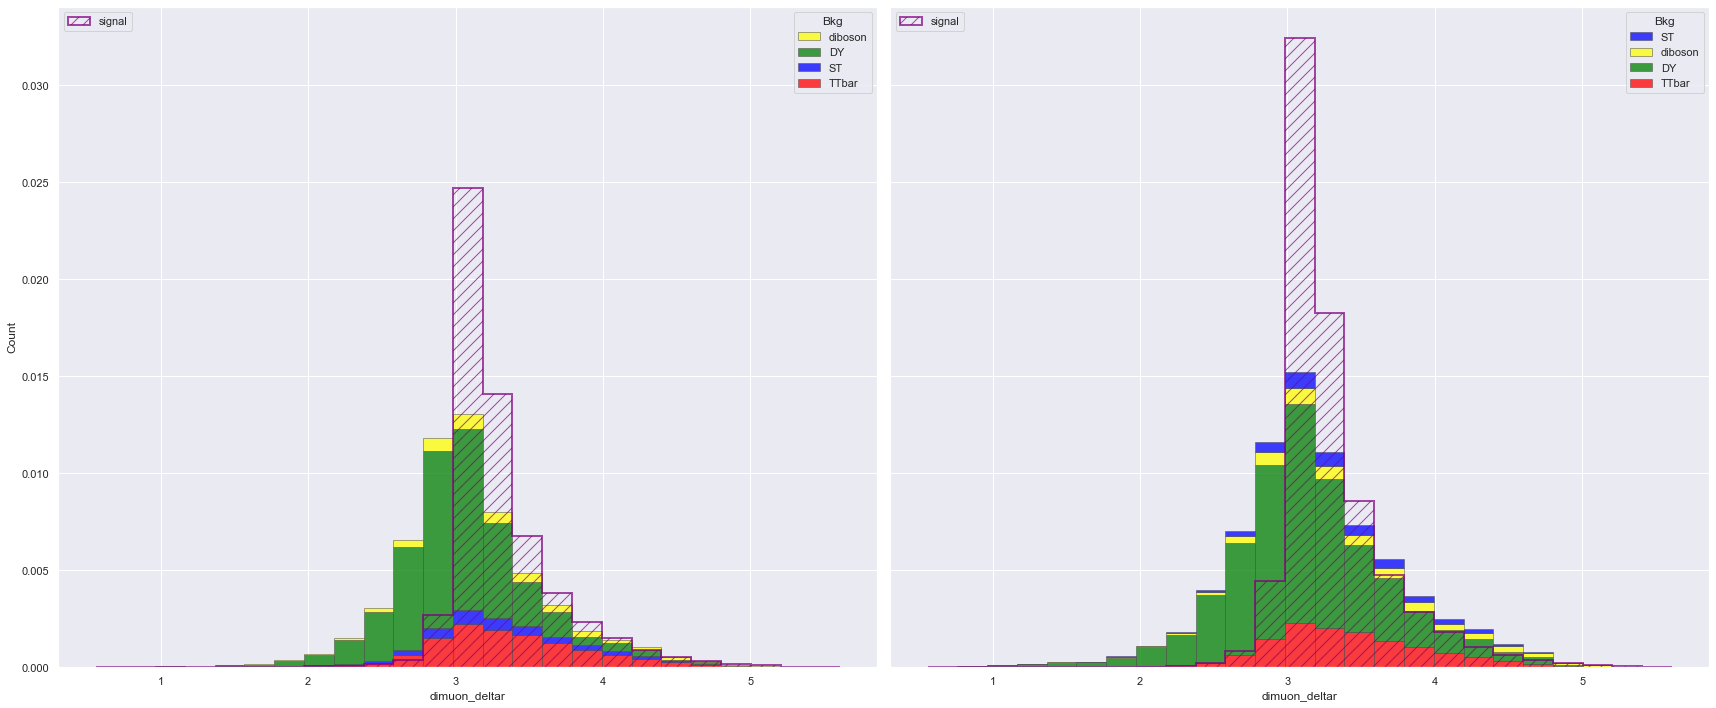

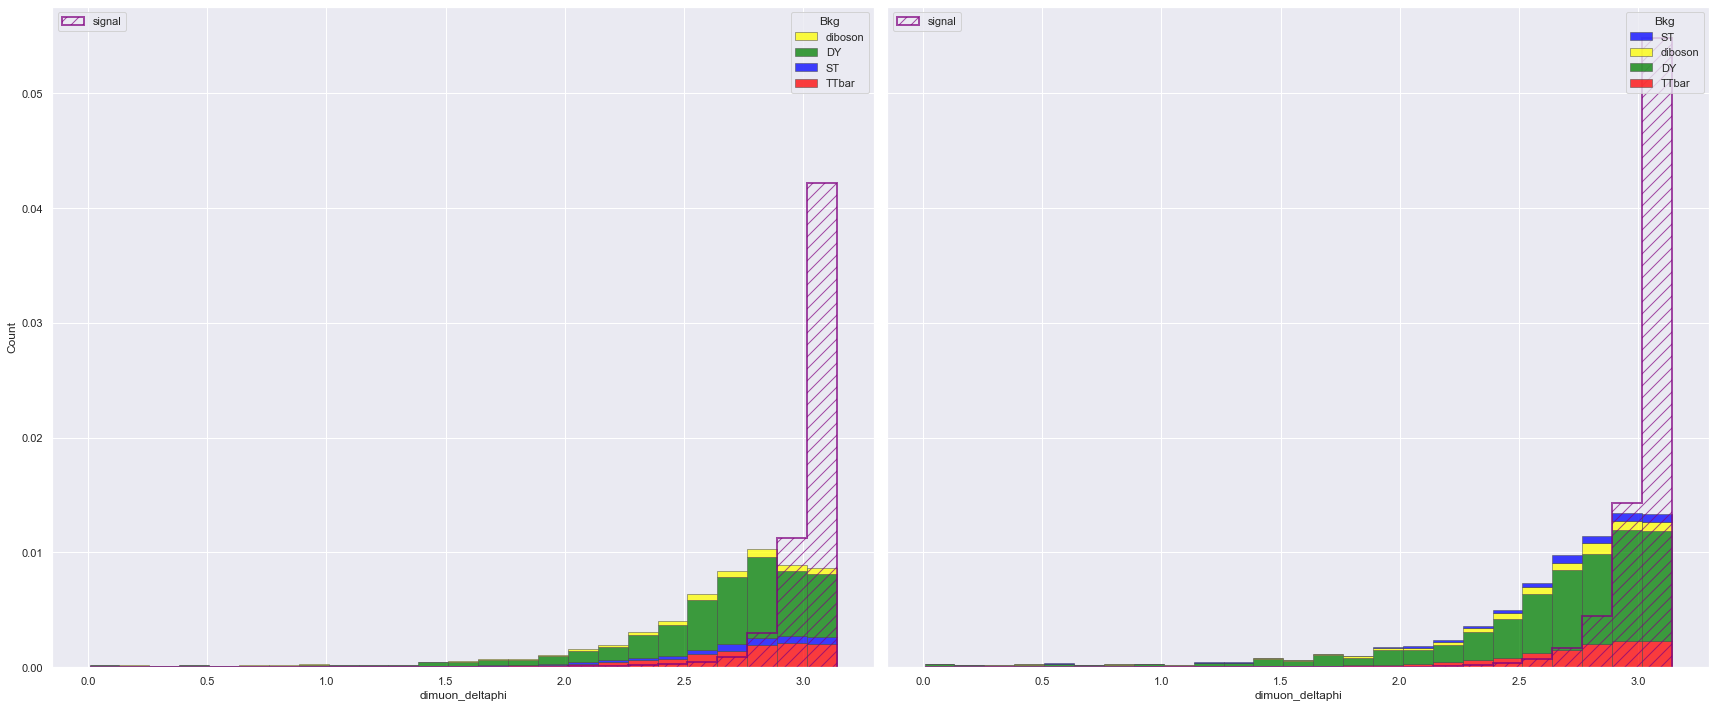

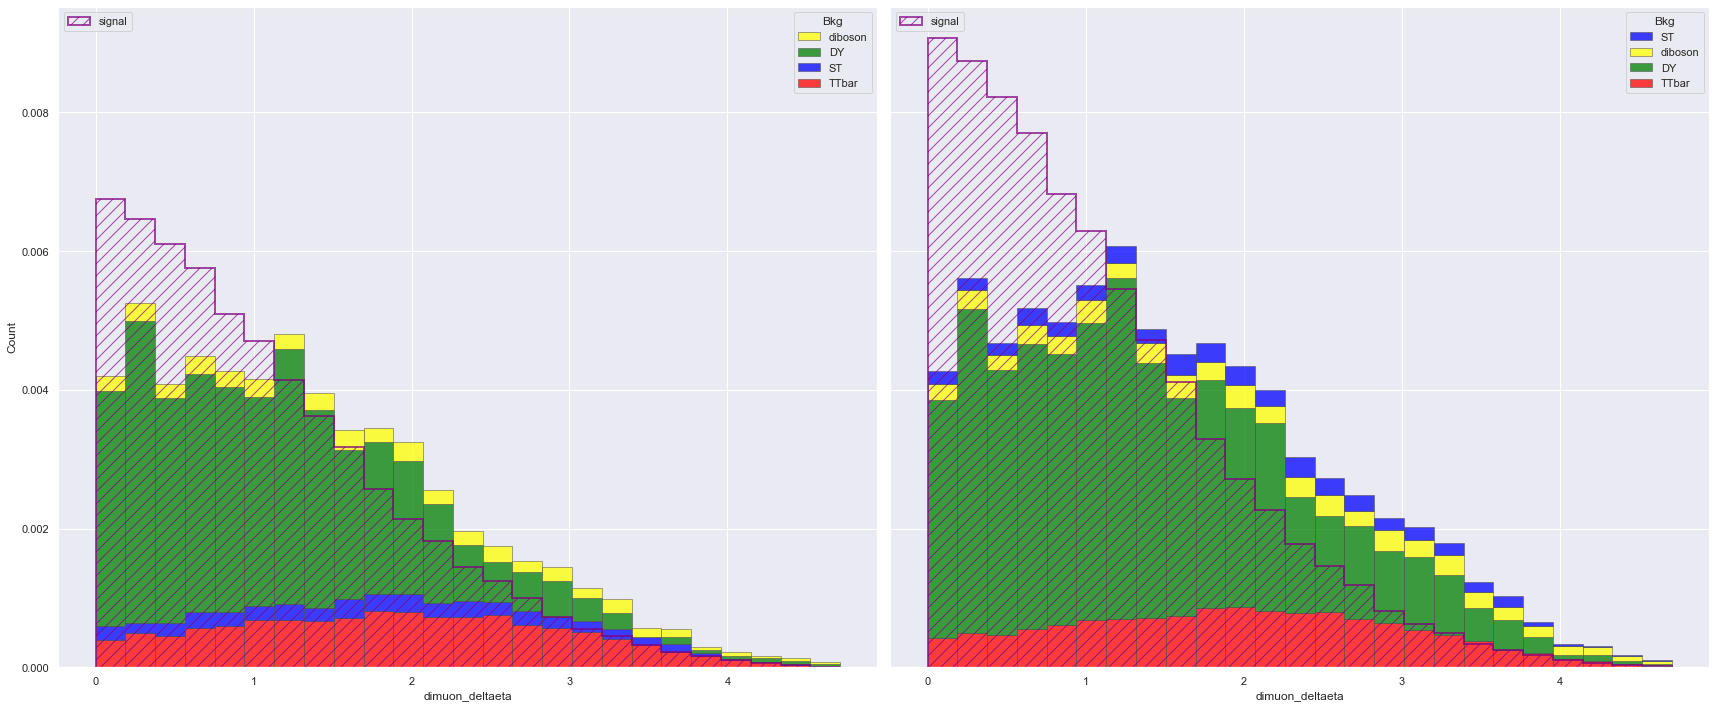

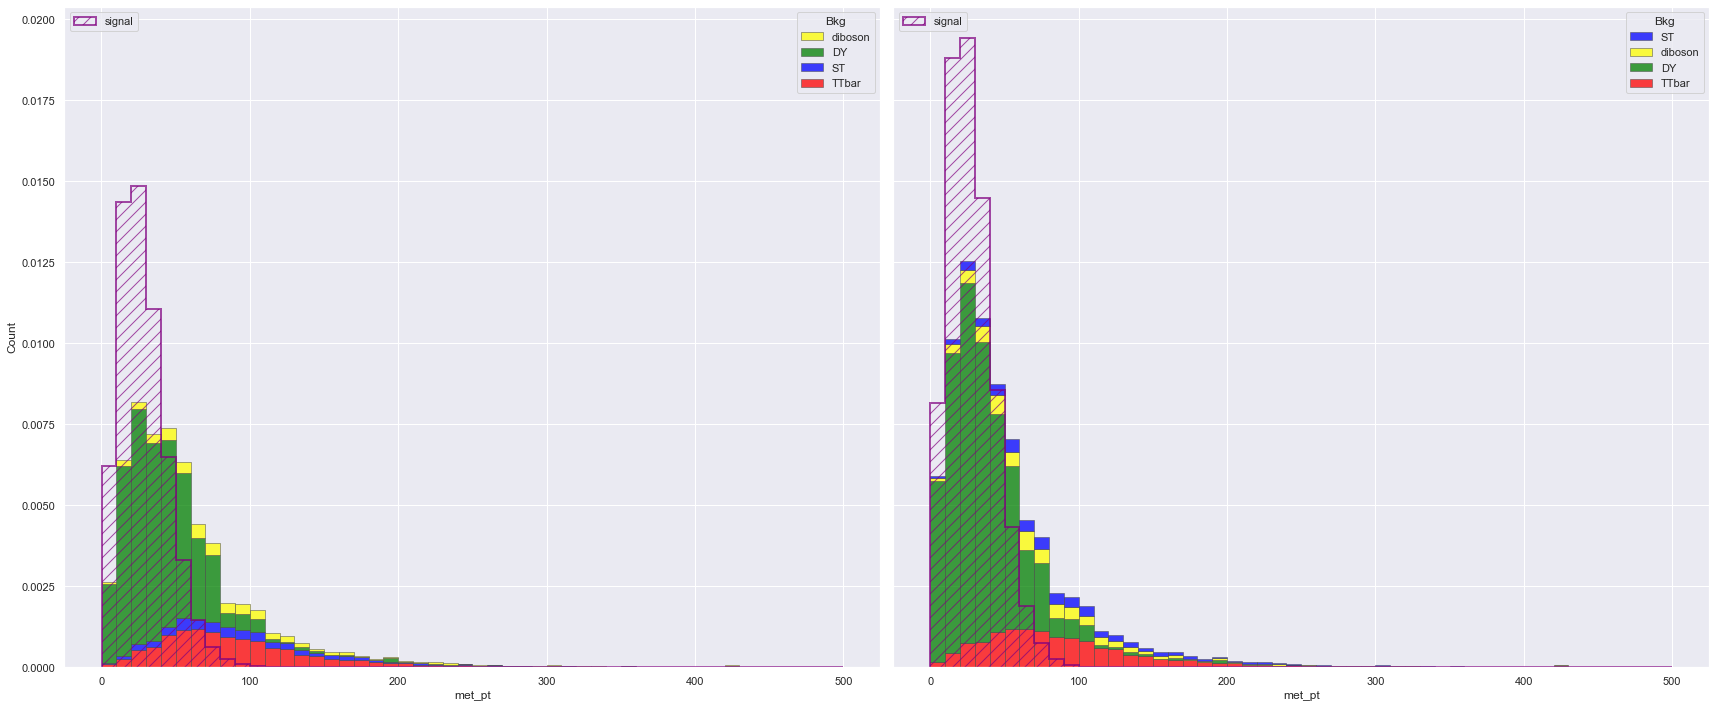

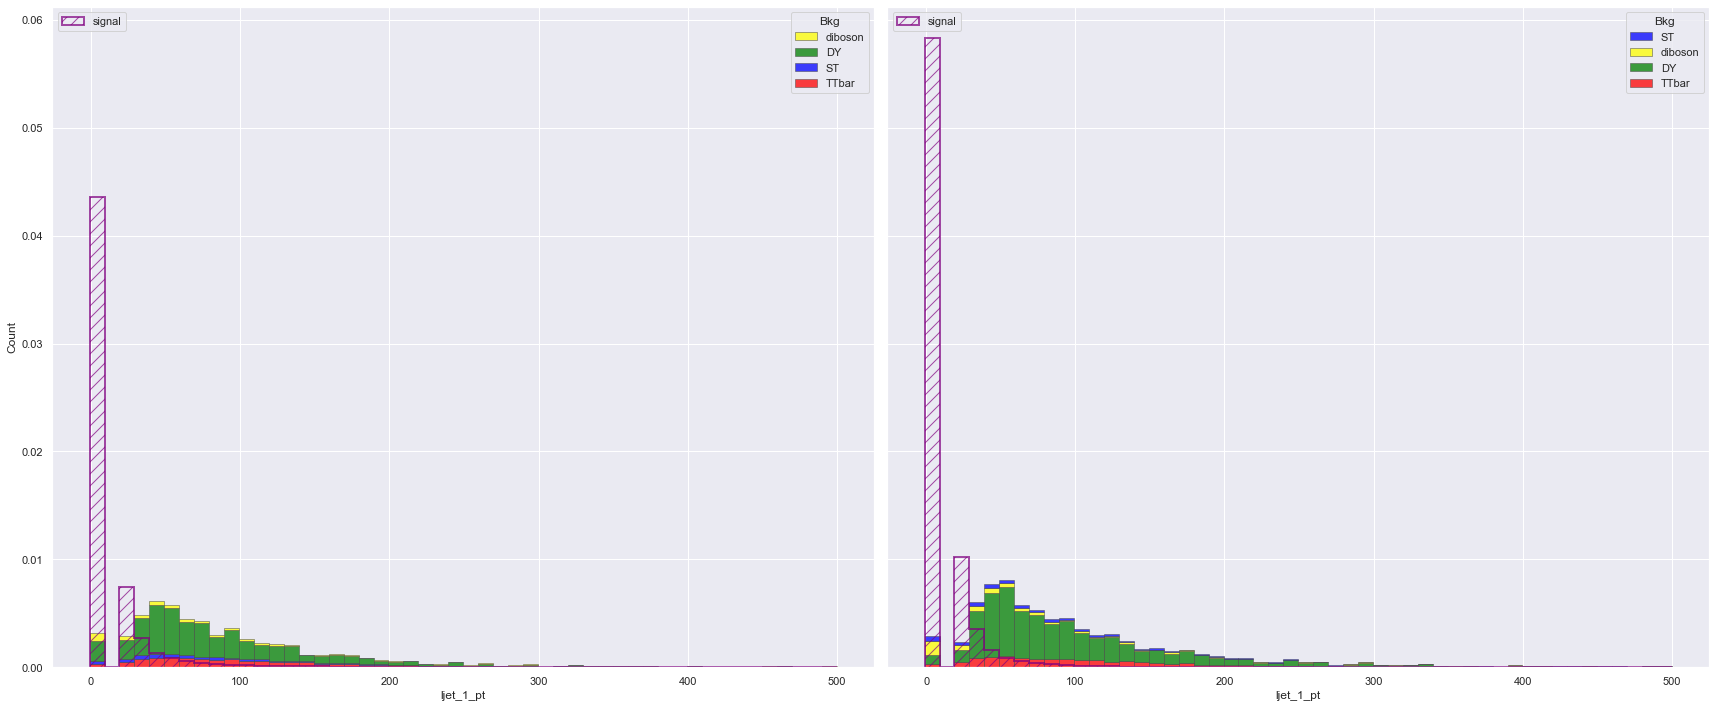

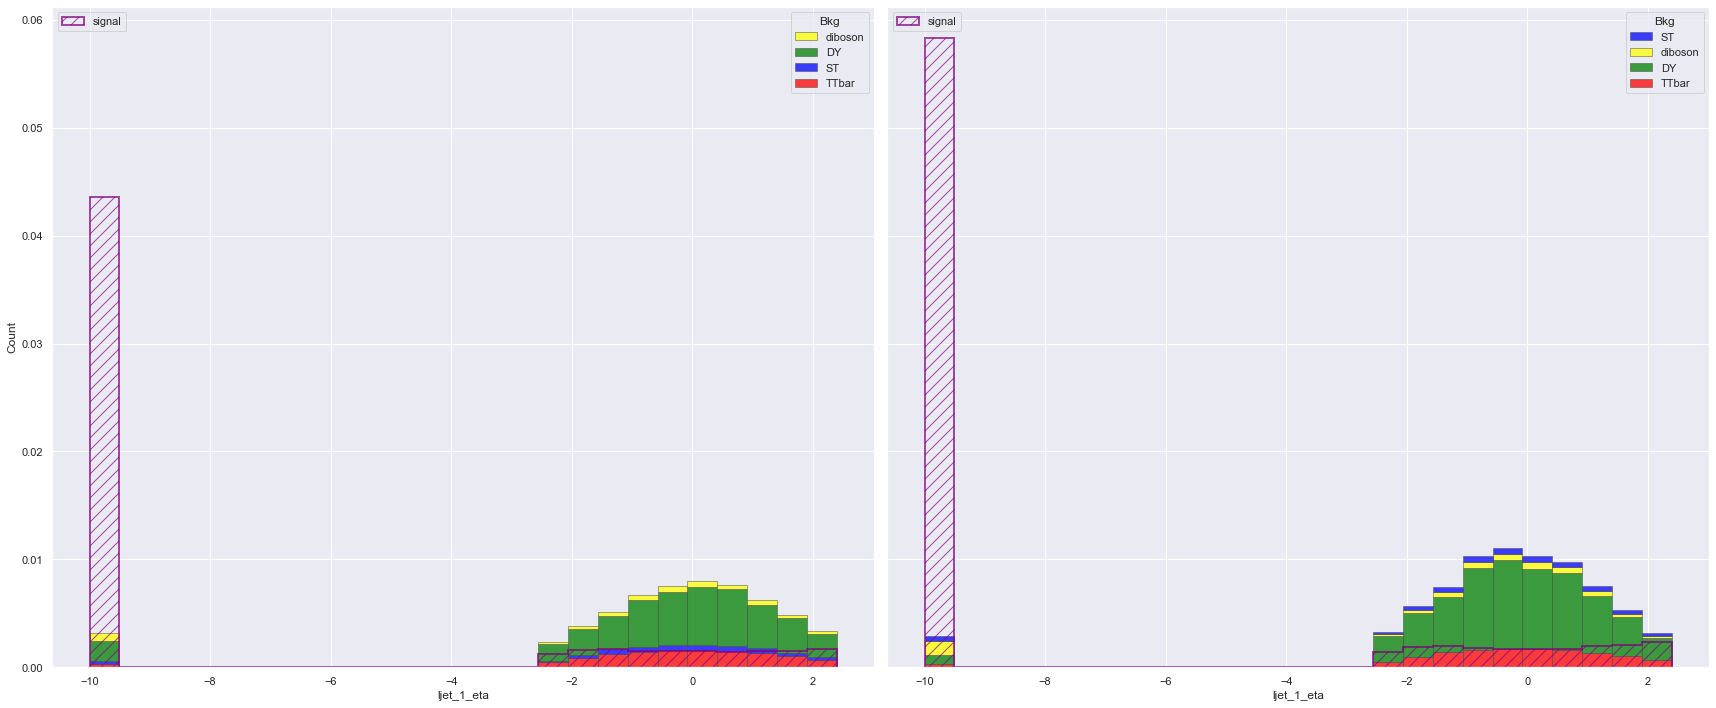

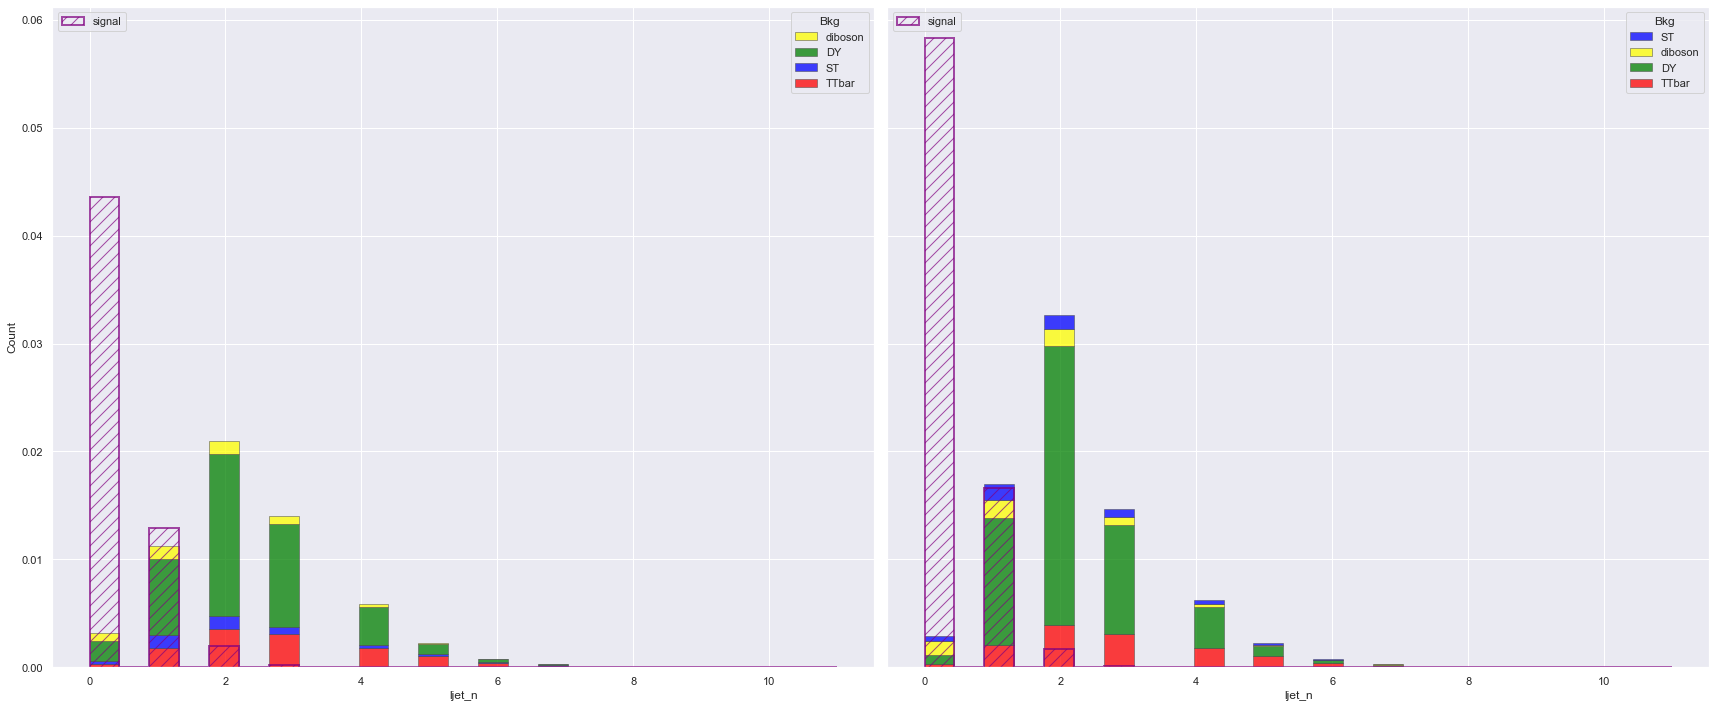

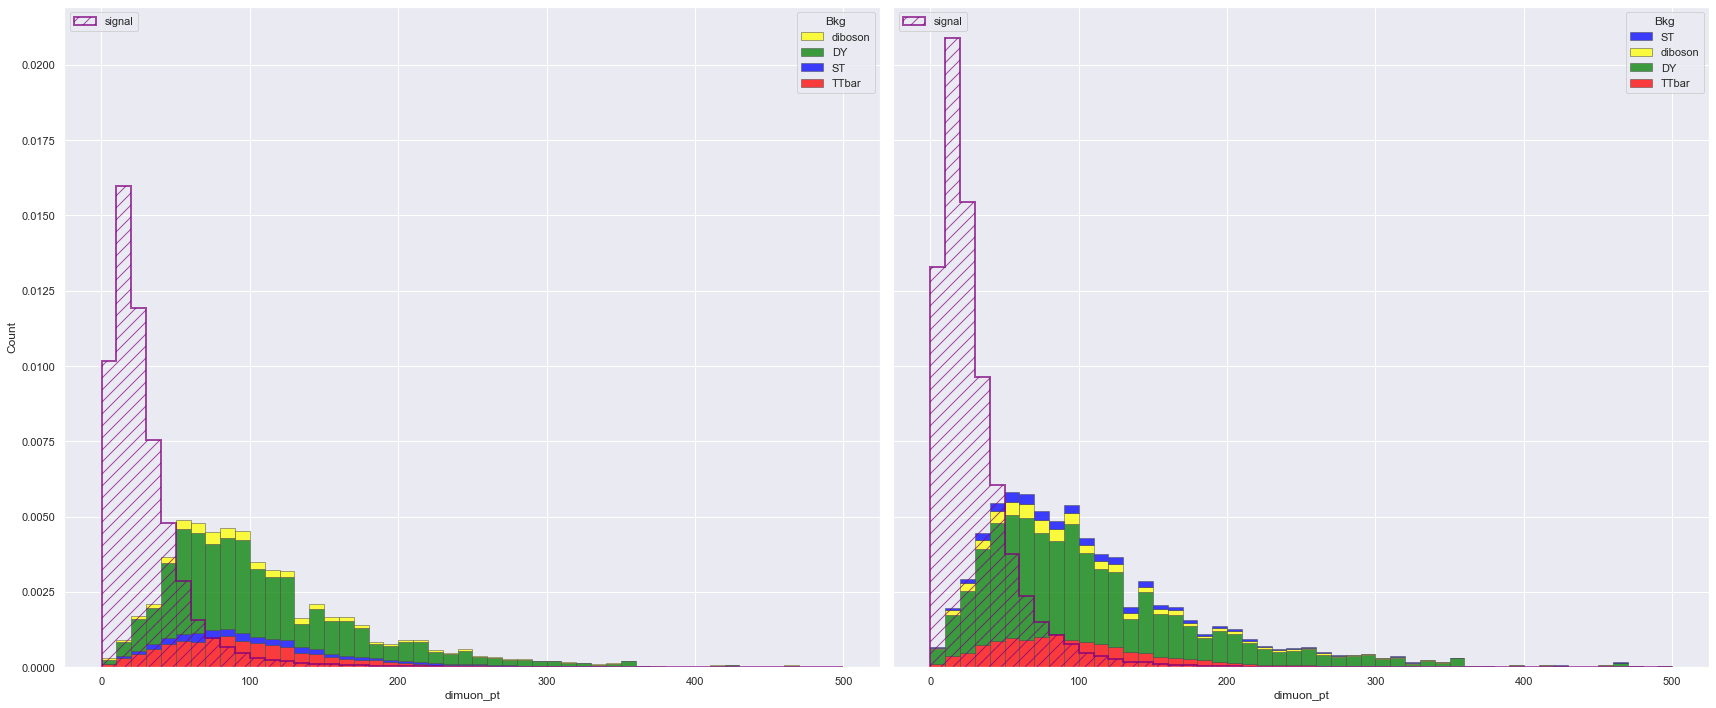

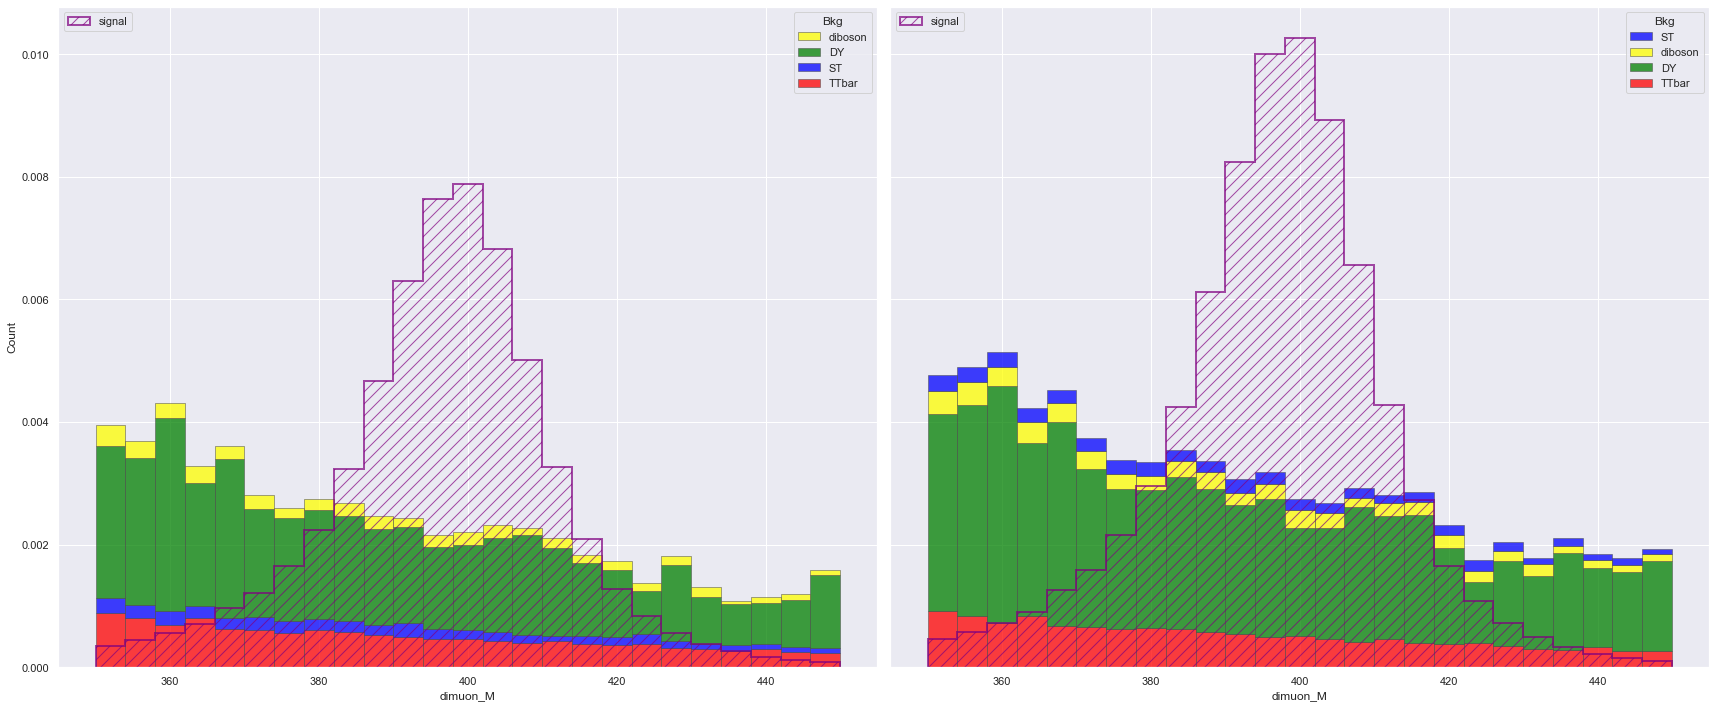

In [24]:
posteriori_plot2(data, models=(model1, model2), 
                 variables=VAR_CAT2 + ['dimuon_pt', 'dimuon_M'], mass=400.0, 
                 cuts=(0.421, 0.421), category=1, case=2, weight=True,
                 path='plot/plot/category 2/bbH/performance/balanced', save='')